In [1]:
from autograd import numpy as np
import autograd.numpy.random as npr
from autograd import grad
from autograd.misc.optimizers import adam, sgd
import pandas as pd
from matplotlib import pyplot as plt
from autograd.scipy.stats import multivariate_normal, norm
from matplotlib.gridspec import GridSpec
import numpy
from matplotlib import cm
from tqdm import tqdm
from numba import jit
from scipy.integrate import dblquad

/home/elisionducoeur/anaconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: covariance is not positive-semidefinite.
  return f_raw(*args, **kwargs)


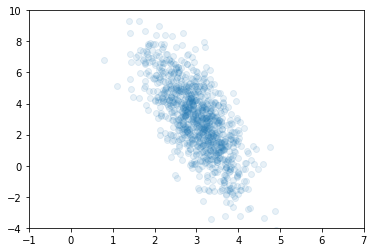

In [2]:
# Target density
n_samples = 1000
xs = 2*np.pi*np.random.random(n_samples) - np.pi
#target_samples = np.array(list(zip(xs, np.sin(xs)+0.1*np.random.randn(n_samples))))

target_samples = np.random.multivariate_normal([3,3], [[1,-5],[0,1]], n_samples)
fig, ax = plt.subplots()
ax.scatter(target_samples[:,0], target_samples[:,1], alpha=0.1)
ax.set(xlim=(-1,7), ylim=(-4,10))
plt.show()

In [3]:
def u1(z, N=1):
    # z is generated data
    # N is normalizing constant
    exp_factor = 1/2*((np.linalg.norm(z, axis=2) - 2)/0.4)**2 - \
                 np.log(np.exp(-1/2*((z[:,:,0] - 2)/0.6)**2) + np.exp(-1/2*((z[:,:,0] + 2)/0.6)**2))
    return N * np.exp(-exp_factor)

def u1_int(x, y):
    exp_factor = 1/2*((np.linalg.norm([x,y])-2)/0.4)**2 - \
                 np.log(np.exp(-1/2*((x-2)/0.6)**2) + np.exp(-1/2*((x+2)/0.6)**2))
    return np.exp(-exp_factor)

def u1_target(z, N=1):
    exp_factor = 1/2*((np.linalg.norm(z, axis=1)-2)/0.4)**2 - \
                 np.log(np.exp(-1/2*((z[:,0]-2)/0.6)**2) + np.exp(-1/2*((z[:,0]+2)/0.6)**2))
    return N*np.exp(-exp_factor)

def u2(z, N=1):
    exp_factor = 1/2*((z[:,:,1] - np.sin(2*np.pi*z[:,:,0]/0.4))/0.4)**2
    return np.exp(-exp_factor)

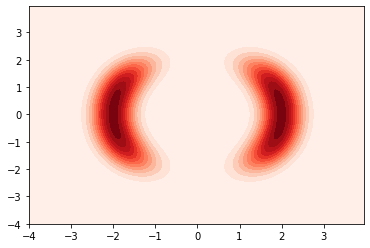

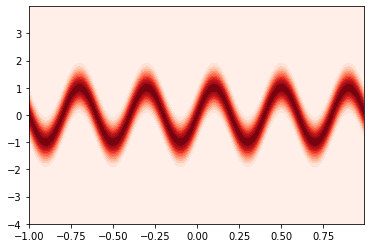

In [4]:
X, Y = numpy.mgrid[-4:4:0.05, -4:4:0.05]
dat = np.dstack((X, Y))
fig, ax = plt.subplots()
ax.contourf(X, Y, u1(dat), cmap='Reds', levels=15)
plt.show()

X, Y = numpy.mgrid[-1:1:0.01, -4:4:0.01]
dat = np.dstack((X, Y))
fig, ax = plt.subplots()
ax.contourf(X, Y, u2(dat), cmap='Reds', levels=15)
plt.show()

result = dblquad(u1_int, -4, 4, lambda x: -4., lambda x: 4.)[0]
u1_normalizing_factor = 1/result

In [5]:
def flow(z, lbda, func): # Planar transformation
    return z + func((z @ lbda[2:4].reshape(-1, 1))+lbda[-1]) @ lbda[:2].reshape(1, -1)

# breaks if using func instead of np.tanh
def psi(z, lbda, func): # Psi used in ELBO
    return np.tanh((samples @ lbda[2:4].reshape(-1, 1))+lbda[-1]) @ lbda[2:4].reshape(1, -1)

def flow_samples(z, flow_func, lbdas): # Does flow for multiple transformations
    for k in range(len(flow_func)):
        z = flow_func[k](z, lbdas[k])
    return np.array(z)

In [6]:
def free_energy(z, lbda, q, p, flows, x, beta=0.1): # ELBO
    # z is samples of shape (S, K)
    # q is distribution z was drawn from
    # p is target distribution (observations?)
    # flows is list of flow functions
    
    # TODO: keep explicit lambda dependence in p(x, z_k) -> will hopefully fix things?
    # But its a joint and they're independent, so not sure how it depends on target
    # Basically just need original and k-th transformation
    
    #q_exp = np.sum(q(z[0]))/len(z[0])
    q_exp = 0
    joint_exp = beta*sum(p(flow_samples(z, flows, lbda)))
    flow_exp = 0
    for k in range(len(lbda)):
        flow_exp += np.sum(np.log(np.abs(1 + np.dot(flows[k](z, lbda[k]) * lbda[k][2:4], lbda[0][:2]))))
    #print("FREE ENERGY: {}".format(flow_exp/len(z) + joint_exp))
    return flow_exp + joint_exp

# Fitting the first (potentially easiest) potential from the paper

[[1. 0. 4. 5. 0.]
 [1. 0. 4. 5. 0.]]


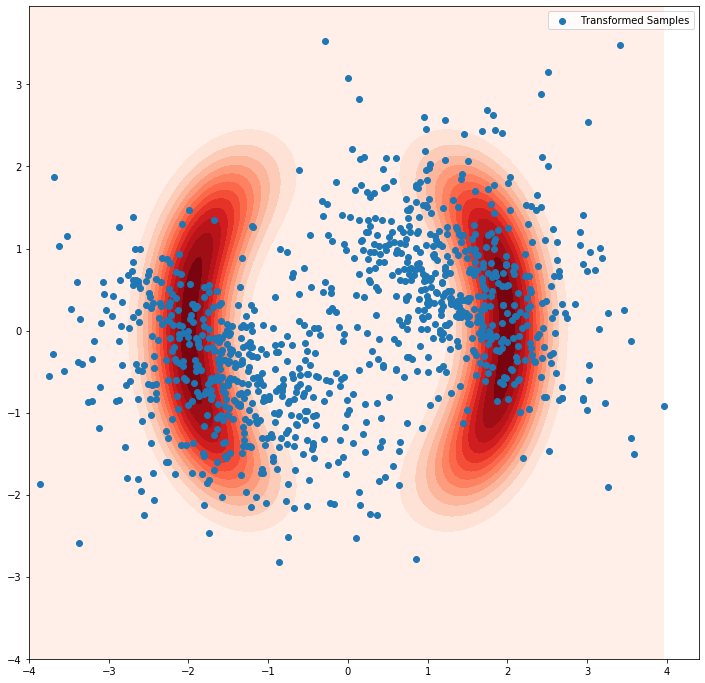

In [7]:
# Samples from initial distribution
samples = np.random.multivariate_normal([0,0], np.eye(2), 1000)

# Setting up flow parameters - splits data vertically, is a good example
lbda = [np.array([-10., 10., 0., 150., 0.1])]


# Set up parameters for learning flow
flows = 2
lbda = np.array([np.ones(5)*2.]*flows)
lbda = np.array([np.array([1., 0., 4., 5., 0.])]*flows)
print(lbda)
#raise
func = lambda x: np.tanh(x)  # Function for transformation
flow_func = [lambda z, lbda: psi(z, lbda, grad(func))]*flows

# Flow samples
samples = flow(samples, lbda[0], func)

# Current and target distributions
p = lambda x: u1_target(x, u1_normalizing_factor)
q = lambda z: np.log(multivariate_normal.pdf(z, [0,0], np.eye(2)))

# Set up Free Energy function to minimize
en = free_energy(samples, lbda, q, p, flow_func, target_samples)
en_func = lambda lmda: free_energy(samples, lmda, q, p, flow_func, target_samples)
grad_en_func = grad(en_func)

# Set up grid to plot
X, Y = numpy.mgrid[-4:4:0.05, -4:4:0.05]
dat = np.dstack((X, Y))

# Plot everything
fig, ax = plt.subplots(figsize=(12,12))
ax.contourf(X, Y, u1(dat), cmap='Reds', levels=15) # Target distribution
ax.scatter(samples[:,0], samples[:,1], label="Transformed Samples")

ax.legend(loc='best')
plt.show()

ORIGINAL LAMDA:
[[1. 0. 4. 5. 0.]
 [1. 0. 4. 5. 0.]]



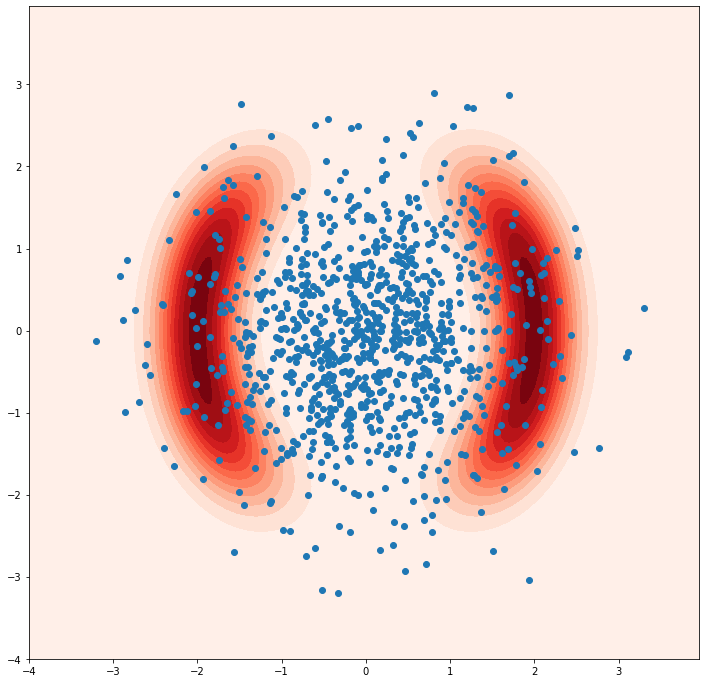

  0%|          | 0/200 [00:00<?, ?it/s]

[[1988.78303137 3107.47348652  193.66140396  269.25795748  187.97184579]
 [   0.            0.          193.78050359  269.05831327  187.67195646]]


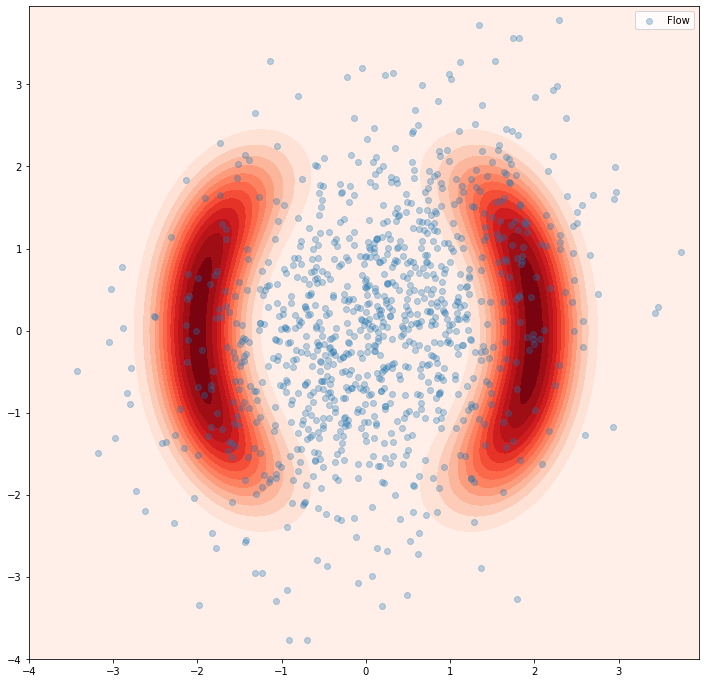

  2%|▏         | 3/200 [00:00<00:39,  4.98it/s]

[[ 1.62716087  3.2558837  17.49312188 35.39471048 40.50646262]
 [ 0.          0.         15.98863502 30.93464856 34.52459751]]
[[5.91645955e-03 4.22682860e-03 5.14978959e-04 3.16204512e-05
  3.49637366e-04]
 [0.00000000e+00 0.00000000e+00 1.95184936e-03 8.34141975e-05
  9.02077918e-04]]
[[ 6.85731956e-05  6.03895420e-05 -9.45710412e-07 -4.76670555e-07
  -4.96561355e-08]
 [ 0.00000000e+00  0.00000000e+00 -6.43827032e-05  8.85111367e-06
   4.07224504e-05]]


  3%|▎         | 6/200 [00:00<00:28,  6.81it/s]

[[-4.96647452e-05 -7.87877218e-05 -2.42345375e-05 -1.02334799e-04
  -8.65431747e-05]
 [ 0.00000000e+00  0.00000000e+00  9.66187013e-06  1.24999568e-05
   7.90925785e-07]]
[[ 1.39336339e-05  3.51836628e-05  2.37950647e-05 -3.10144367e-05
   4.62000501e-04]
 [ 0.00000000e+00  0.00000000e+00 -1.48539673e-05 -1.04442168e-04
   2.33597123e-05]]
[[-9.86774879e-05 -4.84449958e-05  9.52993624e-05 -1.89943784e-05
   1.84223072e-04]
 [ 0.00000000e+00  0.00000000e+00  3.53667679e-04  1.32728367e-04
   6.36452918e-05]]


  5%|▌         | 10/200 [00:00<00:21,  9.03it/s]

[[-7.97992309e-05  1.49755793e-05 -2.63608376e-04 -1.00993209e-04
   4.69005807e-05]
 [ 0.00000000e+00  0.00000000e+00  1.93727190e-05 -6.75038838e-05
  -5.70561179e-05]]
[[ 3.65832492e-04  4.94850401e-04 -8.55505898e-07  1.60418447e-04
  -1.84866523e-04]
 [ 0.00000000e+00  0.00000000e+00 -5.24765730e-05  1.55534594e-06
   5.08314684e-05]]
[[-1.11217941e-04 -5.91588972e-05  3.88869591e-06 -8.98551744e-05
   5.10146010e-04]
 [ 0.00000000e+00  0.00000000e+00  8.63267757e-05 -1.12400428e-04
  -7.04824227e-05]]
[[ 5.92459448e-04  1.32109205e-04  3.97540291e-05  3.49055888e-05
  -6.15079445e-04]
 [ 0.00000000e+00  0.00000000e+00 -7.41720624e-04  1.57509261e-04
  -3.02492211e-04]]


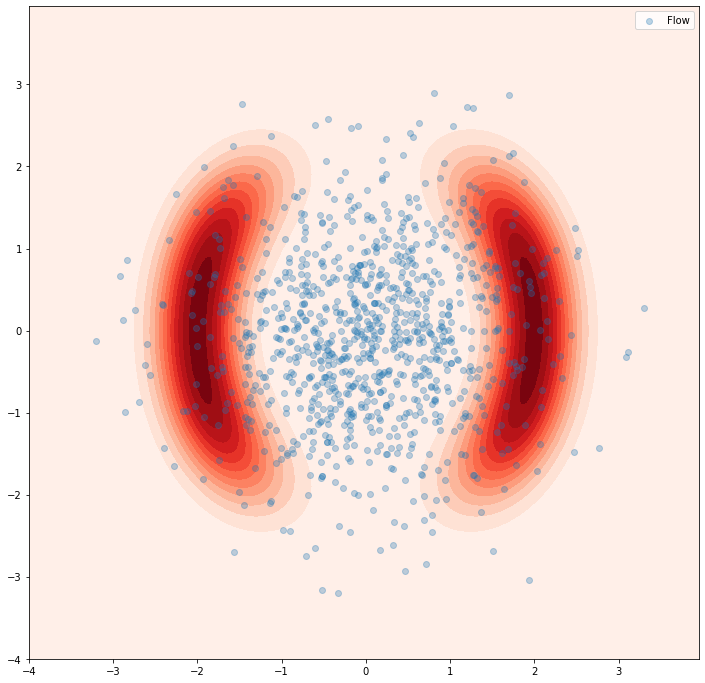

  7%|▋         | 14/200 [00:01<00:21,  8.70it/s]

[[-8.62635622e-06 -5.37928493e-04  2.24305433e-05 -1.82362053e-05
   4.34200483e-05]
 [ 0.00000000e+00  0.00000000e+00  4.10858686e-06 -7.36782183e-07
   5.04493790e-07]]
[[ 2.10076980e-05  1.64756293e-04  2.28140933e-05  5.74549218e-06
  -7.13233958e-06]
 [ 0.00000000e+00  0.00000000e+00 -1.83357321e-05  2.24317507e-05
  -6.42644291e-06]]
[[-3.25227794e-05 -3.16850623e-04  2.16698336e-04 -6.24640235e-04
   2.41514772e-04]
 [ 0.00000000e+00  0.00000000e+00  1.99460607e-05  1.29172388e-04
   2.44744394e-04]]


  8%|▊         | 16/200 [00:01<00:18, 10.04it/s]

[[-2.62745763e-04 -4.11932073e-05  3.31037152e-04 -8.30263132e-05
   4.80921990e-04]
 [ 0.00000000e+00  0.00000000e+00 -8.90418560e-05 -9.85209861e-06
   1.69063364e-04]]
[[ 8.44619430e-05  6.19797495e-05 -1.54887629e-05 -3.47398446e-05
   4.29849102e-04]
 [ 0.00000000e+00  0.00000000e+00  3.86066743e-04 -2.09016146e-04
   3.15914116e-04]]
[[ 1.50240324e-04  9.92234583e-05  2.23243599e-06 -2.16780548e-05
  -4.98495416e-06]
 [ 0.00000000e+00  0.00000000e+00  7.80043813e-05  4.30344889e-05
   3.68981145e-05]]


 10%|█         | 20/200 [00:01<00:15, 11.45it/s]

[[-1.54972201e-04 -4.10526898e-06 -2.11766925e-04  9.50943409e-05
  -1.61785283e-04]
 [ 0.00000000e+00  0.00000000e+00 -5.58915955e-05  5.97327700e-05
  -6.91127493e-05]]
[[-7.59032946e-05 -3.41794884e-04 -6.25932634e-06  4.20834247e-06
   1.98291846e-05]
 [ 0.00000000e+00  0.00000000e+00 -4.28548031e-04 -9.85359913e-05
  -5.30350993e-05]]
[[ 1.30520250e-04  1.28936463e-04  1.66372716e-06  3.95337845e-06
  -1.39119974e-05]
 [ 0.00000000e+00  0.00000000e+00 -3.55638191e-05  3.30599396e-05
  -6.07757016e-05]]
[[-1.15664825e-04 -1.52309257e-05  3.53072285e-05 -6.73233003e-05
   5.39829168e-06]
 [ 0.00000000e+00  0.00000000e+00  1.68595123e-05 -1.06085744e-04
   7.59893486e-05]]


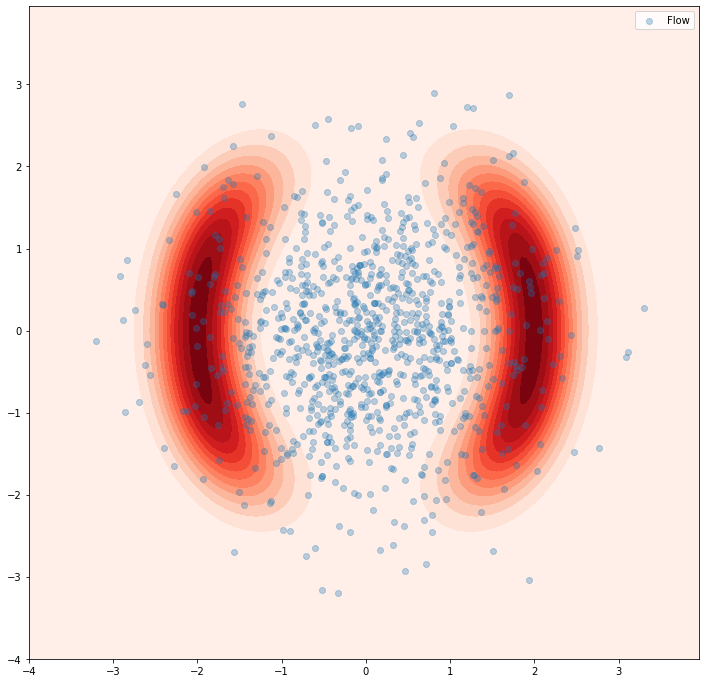

 12%|█▏        | 24/200 [00:02<00:17,  9.80it/s]

[[5.07013163e-05 8.40847109e-04 8.36226531e-05 7.12083619e-04
  2.62347880e-04]
 [0.00000000e+00 0.00000000e+00 8.22972296e-06 5.79872296e-05
  6.30439040e-05]]
[[-8.86481863e-05 -1.19254217e-04  3.59563238e-05  1.74080512e-04
   8.94338368e-05]
 [ 0.00000000e+00  0.00000000e+00  1.03632358e-05 -4.74679885e-06
  -3.72698832e-05]]
[[-3.86580691e-04 -6.07354411e-06  5.56048008e-05 -2.74798719e-05
   2.91351188e-04]
 [ 0.00000000e+00  0.00000000e+00 -1.45606431e-04 -1.15597876e-05
   9.55284824e-05]]


 13%|█▎        | 26/200 [00:02<00:17, 10.06it/s]

[[-1.02688628e-04 -2.28623960e-04 -7.89816809e-05 -3.21982398e-04
  -1.62242808e-04]
 [ 0.00000000e+00  0.00000000e+00  2.63796788e-04 -2.80473971e-04
  -9.99721774e-06]]
[[-1.86034433e-05 -1.53142055e-04 -9.76033713e-05 -1.39641284e-04
   8.71096414e-05]
 [ 0.00000000e+00  0.00000000e+00 -2.81890562e-07  7.68850068e-07
   4.56639320e-05]]
[[-2.91165724e-04 -7.75414785e-05 -3.64056477e-05  1.84373526e-04
   9.91071907e-05]
 [ 0.00000000e+00  0.00000000e+00  8.81563840e-06 -2.78530465e-05
   1.54269466e-06]]


 15%|█▌        | 30/200 [00:02<00:14, 11.54it/s]

[[ 3.05611094e-05 -1.26741689e-04 -2.66119802e-04 -1.04558378e-04
   1.77163386e-04]
 [ 0.00000000e+00  0.00000000e+00 -2.60181098e-04 -6.44725484e-06
   1.95310928e-04]]
[[-7.15450022e-04 -2.57820966e-05 -4.58311440e-05 -3.05255569e-04
   2.04180619e-05]
 [ 0.00000000e+00  0.00000000e+00 -9.31144211e-05  1.50049424e-04
  -1.50742830e-04]]
[[-3.64054018e-06  2.60530806e-04 -2.13142782e-05 -2.97021552e-06
   7.50979720e-05]
 [ 0.00000000e+00  0.00000000e+00  5.16308022e-05  1.22390469e-04
   1.43078741e-04]]
[[-7.47535084e-05 -5.12567125e-05  9.22585186e-06  5.03324681e-05
   9.64281541e-05]
 [ 0.00000000e+00  0.00000000e+00  1.64995394e-04 -2.45139825e-04
   2.28553515e-07]]


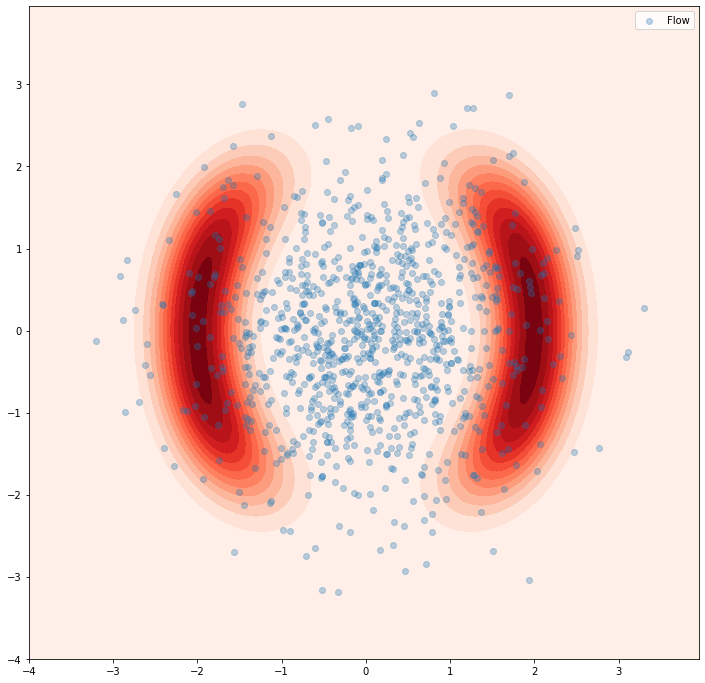

 17%|█▋        | 34/200 [00:03<00:19,  8.70it/s]

[[ 5.82484620e-06  1.66539607e-04  2.52623593e-05 -3.48334999e-04
   1.20476064e-03]
 [ 0.00000000e+00  0.00000000e+00 -1.62934455e-05  1.93150071e-04
   7.45903767e-05]]
[[-1.51853093e-04 -3.11197818e-04  1.68523028e-04 -4.42816258e-04
  -2.05880676e-04]
 [ 0.00000000e+00  0.00000000e+00 -5.16683399e-05  1.56570191e-05
   3.65015573e-05]]
[[-2.85026731e-04 -5.39537751e-05 -5.35751752e-06  5.01154576e-06
  -5.51566395e-06]
 [ 0.00000000e+00  0.00000000e+00 -6.68672835e-05  1.09450843e-04
  -5.54886479e-05]]


 18%|█▊        | 36/200 [00:03<00:17,  9.57it/s]

[[-3.75329028e-05 -3.86167426e-05  4.61212318e-04  1.95199990e-04
  -3.55254447e-04]
 [ 0.00000000e+00  0.00000000e+00  5.82344264e-04  5.05161040e-04
  -3.82884675e-04]]
[[-1.07026343e-03 -6.37595411e-04 -5.15776702e-05 -1.27576449e-06
   5.48633943e-05]
 [ 0.00000000e+00  0.00000000e+00  1.55724401e-04  9.40243317e-06
   7.15314871e-05]]
[[ 3.03344061e-04  4.51504810e-06 -1.26364308e-04 -7.39986549e-06
  -2.01529068e-05]
 [ 0.00000000e+00  0.00000000e+00 -3.24353170e-04  9.80543122e-06
  -2.02084729e-04]]


 20%|██        | 40/200 [00:04<00:15, 10.52it/s]

[[ 2.52170457e-04 -7.69425179e-06 -1.20289385e-04 -1.32678051e-05
   1.62362303e-04]
 [ 0.00000000e+00  0.00000000e+00  4.40065522e-05 -2.41794454e-05
   4.57796542e-05]]
[[-5.99850454e-05 -1.82510654e-04  3.48647576e-06 -1.35487023e-05
   3.41552519e-06]
 [ 0.00000000e+00  0.00000000e+00 -7.96482455e-06 -1.99145545e-04
   1.27125627e-04]]
[[-1.45970204e-04 -2.20720782e-06  7.19327746e-06  6.59628805e-06
   9.18597333e-06]
 [ 0.00000000e+00  0.00000000e+00 -1.56157308e-04  1.32057717e-05
   2.28946319e-04]]
[[ 5.85654732e-05  1.07986915e-04 -2.10262980e-05  2.07713532e-06
  -4.49510914e-05]
 [ 0.00000000e+00  0.00000000e+00  7.47555844e-05 -2.16633470e-04
  -1.84411034e-04]]


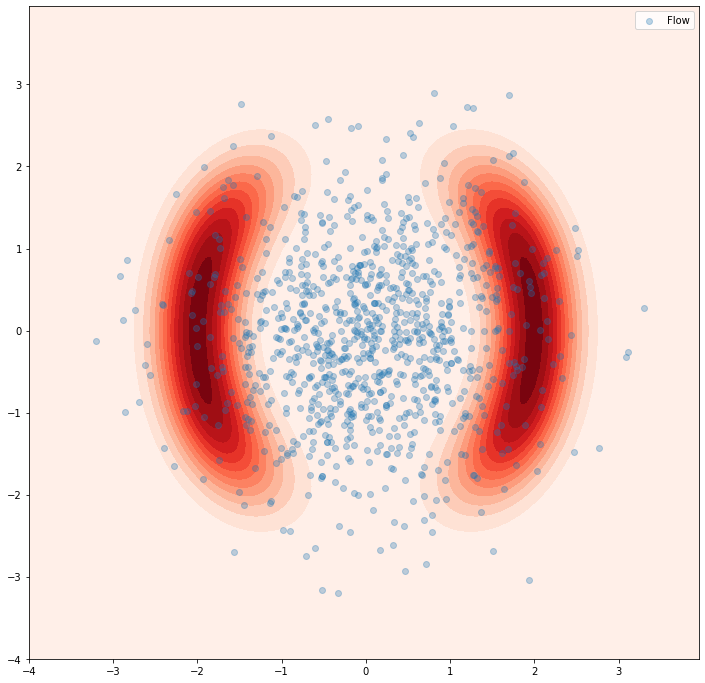

 22%|██▏       | 43/200 [00:04<00:19,  7.93it/s]

[[ 6.55548488e-06  1.60714325e-04  3.97062804e-06 -3.37464275e-05
   1.40402174e-04]
 [ 0.00000000e+00  0.00000000e+00  1.56343340e-05  5.54050778e-05
   3.33593292e-04]]
[[-3.07501307e-05 -3.53723048e-05 -5.84021466e-05 -6.18870940e-05
  -1.81173793e-04]
 [ 0.00000000e+00  0.00000000e+00  7.74340985e-05  1.41638574e-05
  -1.62126225e-04]]


 23%|██▎       | 46/200 [00:04<00:17,  8.80it/s]

[[ 5.70922045e-05  6.42799593e-05  1.58756734e-05 -1.22459136e-04
  -5.70823281e-05]
 [ 0.00000000e+00  0.00000000e+00  1.92556920e-04  2.28170087e-05
  -9.92708204e-05]]
[[-3.96221872e-05 -2.13831499e-05  9.93313961e-06  8.15830925e-05
   1.22025706e-05]
 [ 0.00000000e+00  0.00000000e+00  1.55739040e-06  1.29956812e-05
   3.82564263e-05]]
[[ 0.0013099   0.00080465 -0.0020312  -0.00211515 -0.0002183 ]
 [ 0.          0.          0.0001798  -0.00039637  0.00027601]]


 24%|██▍       | 48/200 [00:04<00:15, 10.07it/s]

[[-4.83290130e-04  4.74420362e-05  1.04943542e-03 -1.04221690e-04
  -2.98801835e-04]
 [ 0.00000000e+00  0.00000000e+00  6.97542081e-05  2.52750964e-04
   3.35169409e-05]]
[[-1.43358934e-04 -1.70429205e-04 -3.09332999e-05 -7.33360193e-06
   5.78567268e-05]
 [ 0.00000000e+00  0.00000000e+00  6.64976507e-05  3.16496277e-05
   2.03817283e-05]]
[[-1.74084460e-05 -8.95985739e-05 -8.16373294e-05  9.28368296e-05
   4.98255982e-05]
 [ 0.00000000e+00  0.00000000e+00 -1.13493490e-05  5.93309337e-06
  -5.22624393e-05]]


 25%|██▌       | 50/200 [00:05<00:14, 10.50it/s]

[[-5.27050912e-05 -1.57572337e-04 -7.29495266e-05  8.80284646e-05
  -1.22545487e-05]
 [ 0.00000000e+00  0.00000000e+00 -8.90649810e-05  6.27207755e-04
  -4.52339373e-04]]
[[ 1.16054350e-04  9.42467017e-05  4.78688634e-05 -2.12885037e-06
   3.66308322e-05]
 [ 0.00000000e+00  0.00000000e+00 -2.67373093e-04 -8.83542314e-06
   1.65888217e-04]]


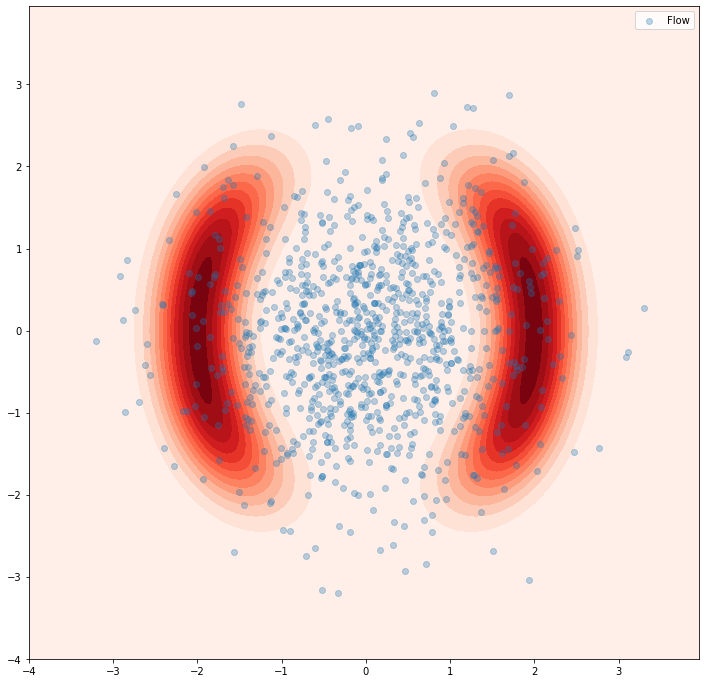

 27%|██▋       | 54/200 [00:05<00:16,  8.74it/s]

[[-1.35204589e-05 -3.52356272e-05 -5.99857347e-05  3.26092748e-05
   6.24602687e-05]
 [ 0.00000000e+00  0.00000000e+00 -6.01751135e-05 -3.54089666e-05
   5.78971237e-06]]
[[ 1.31035384e-04  1.15209936e-05 -5.14817980e-05  1.62822253e-05
   3.90590973e-06]
 [ 0.00000000e+00  0.00000000e+00 -2.06661623e-04 -9.34649418e-05
   9.10338979e-05]]
[[ 9.91776604e-06  1.75664246e-04 -2.19598419e-05 -1.05412073e-04
   8.57094910e-05]
 [ 0.00000000e+00  0.00000000e+00 -2.81523885e-07  6.42971723e-06
   1.57677921e-06]]


 28%|██▊       | 56/200 [00:05<00:15,  9.54it/s]

[[ 8.80167053e-06  4.18779044e-05  8.50542791e-06  6.30708236e-05
  -9.67360116e-05]
 [ 0.00000000e+00  0.00000000e+00 -7.14420145e-06 -2.51332287e-05
  -1.10027608e-05]]
[[-1.22476091e-05  5.09861940e-05  7.45692679e-06 -1.02398940e-04
  -4.59827328e-05]
 [ 0.00000000e+00  0.00000000e+00 -7.80799914e-06 -2.27421806e-05
  -3.73567228e-07]]


 29%|██▉       | 58/200 [00:06<00:14,  9.52it/s]

[[-1.15385638e-04 -3.42251221e-05 -4.54008360e-05  1.43813651e-04
   2.19172405e-05]
 [ 0.00000000e+00  0.00000000e+00  1.17592842e-06  3.04886311e-06
   1.51549895e-06]]
[[ 2.13946000e-05 -1.17569557e-06 -1.49036328e-07  1.82607557e-06
  -4.79421334e-05]
 [ 0.00000000e+00  0.00000000e+00 -7.25249014e-05  2.29953170e-06
   3.70704653e-05]]
[[-9.98793704e-05  2.45136658e-05  5.00424605e-04 -1.22748000e-04
  -2.16496707e-04]
 [ 0.00000000e+00  0.00000000e+00 -2.13656941e-04  1.18338769e-04
  -2.43127881e-05]]


 30%|███       | 60/200 [00:06<00:13, 10.59it/s]

[[ 5.51259626e-05  2.15599287e-05  2.11168519e-04 -3.34785586e-05
   1.00550840e-03]
 [ 0.00000000e+00  0.00000000e+00  7.09791534e-05 -7.30806985e-05
  -4.89886812e-05]]
[[-4.39172984e-06 -4.53619472e-05  2.46128149e-05 -8.60596756e-06
  -5.55346094e-07]
 [ 0.00000000e+00  0.00000000e+00  1.79099634e-05 -1.18039863e-05
   3.85232448e-06]]


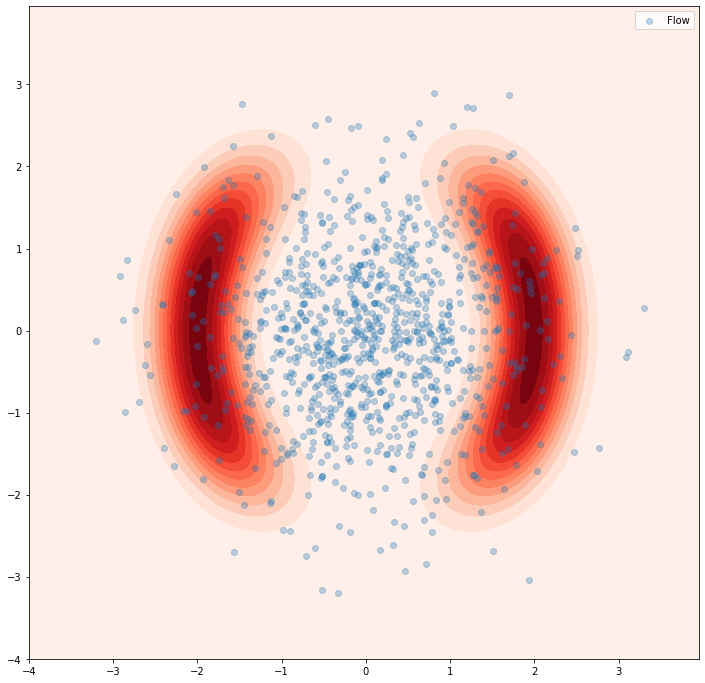

 32%|███▏      | 64/200 [00:06<00:15,  8.67it/s]

[[-2.60096594e-05 -5.19995722e-05  3.81422302e-05 -9.57063604e-06
   2.52628715e-05]
 [ 0.00000000e+00  0.00000000e+00 -1.55015220e-04 -3.02209484e-05
   9.68517780e-05]]
[[-6.41385780e-05 -6.82143421e-05  5.70699623e-05 -2.91326257e-04
   5.10920031e-05]
 [ 0.00000000e+00  0.00000000e+00  1.20727645e-04  3.69569659e-05
   5.16540774e-05]]
[[ 3.24755823e-05  3.14520414e-05  1.23453399e-05  4.08832470e-05
   1.30572664e-05]
 [ 0.00000000e+00  0.00000000e+00  3.08522902e-05 -3.75857851e-04
   5.84479933e-05]]


 33%|███▎      | 66/200 [00:06<00:14,  9.38it/s]

[[ 2.15293448e-04  4.35354791e-04 -7.61415097e-06  1.26058743e-04
  -8.72007506e-06]
 [ 0.00000000e+00  0.00000000e+00 -2.97016836e-05  5.86404814e-04
  -8.67905867e-04]]
[[ 9.66621149e-07 -3.22057145e-04 -1.40505071e-04  4.63489296e-04
  -2.88754635e-04]
 [ 0.00000000e+00  0.00000000e+00 -3.53881680e-05  5.37261084e-06
   1.38287745e-04]]
[[-3.84142104e-04 -1.75488418e-04  1.98269666e-05  2.26720227e-05
   1.48983530e-05]
 [ 0.00000000e+00  0.00000000e+00 -8.24985250e-04 -1.43326263e-04
   1.26006476e-03]]


 35%|███▌      | 70/200 [00:07<00:12, 10.69it/s]

[[-1.07003069e-03 -5.32020824e-04  2.40182872e-04  4.78575224e-05
  -2.96953426e-04]
 [ 0.00000000e+00  0.00000000e+00 -7.36908892e-04 -1.38962583e-04
  -3.15978777e-04]]
[[ 5.41174562e-07 -5.28156860e-05 -3.77824983e-06  8.76981480e-05
   9.00375059e-05]
 [ 0.00000000e+00  0.00000000e+00  9.27255602e-06  2.80720462e-05
   1.88047488e-05]]
[[-7.64315910e-05 -2.95883323e-04 -7.73083732e-06 -3.04758822e-07
   2.52255310e-06]
 [ 0.00000000e+00  0.00000000e+00  4.16500642e-04  3.38928569e-05
   1.54650559e-04]]
[[-1.77472545e-04 -2.45561802e-03 -2.56292643e-04 -2.03220243e-03
   1.58349501e-03]
 [ 0.00000000e+00  0.00000000e+00  2.11615945e-05  5.78184609e-05
   2.34161387e-05]]


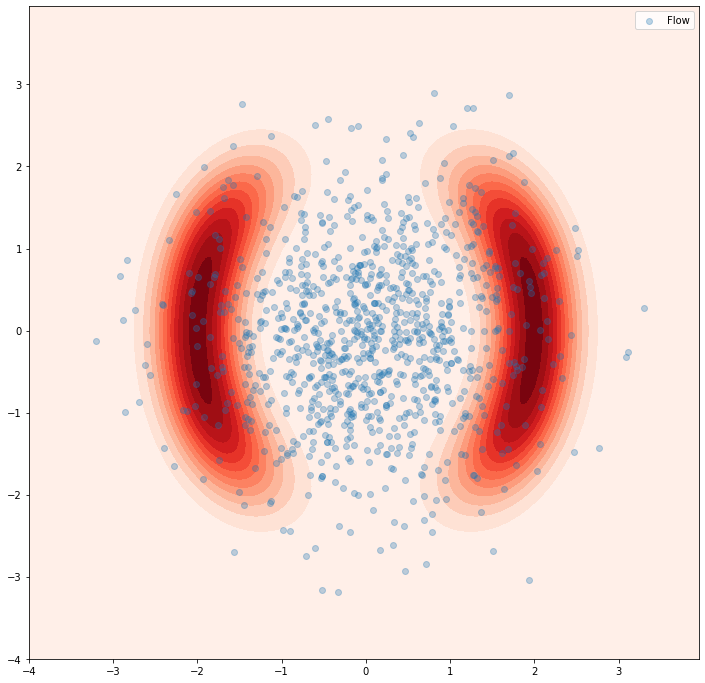

 37%|███▋      | 74/200 [00:07<00:13,  9.13it/s]

[[-5.11043807e-05 -3.72471038e-04 -1.94891558e-04  5.51620535e-04
  -3.71860885e-04]
 [ 0.00000000e+00  0.00000000e+00  1.04757489e-04 -3.50932981e-06
   3.12334530e-05]]
[[ 2.65856040e-04  5.74929732e-04  1.86490791e-04 -3.74301224e-05
   2.55021516e-04]
 [ 0.00000000e+00  0.00000000e+00 -6.75393701e-04 -7.71305585e-05
   3.60422358e-04]]
[[ 8.46168834e-04  2.83673778e-04 -3.14070540e-06 -8.48795733e-05
   5.79197913e-05]
 [ 0.00000000e+00  0.00000000e+00 -4.19669507e-04 -3.73986212e-04
   3.99447220e-04]]
[[-4.17087114e-04 -5.09358532e-04 -3.06066845e-04 -1.78601923e-04
   3.74153323e-06]
 [ 0.00000000e+00  0.00000000e+00  2.82823698e-04  4.36176559e-05
   7.44427279e-05]]


 39%|███▉      | 78/200 [00:08<00:11, 10.70it/s]

[[ 5.92050021e-07 -1.48516837e-05  1.16672772e-05  2.19515520e-05
  -2.76320368e-05]
 [ 0.00000000e+00  0.00000000e+00  3.87132795e-06 -2.87067558e-05
  -1.81432791e-04]]
[[ 1.19737866e-03 -3.09547481e-05  9.89117214e-04 -7.09153153e-05
   9.79142916e-04]
 [ 0.00000000e+00  0.00000000e+00 -1.56882768e-05 -1.27243537e-05
   1.38274707e-05]]
[[ 2.24343939e-04  1.35412965e-04  1.29997270e-04 -1.16494009e-08
   3.66868741e-05]
 [ 0.00000000e+00  0.00000000e+00 -5.82411222e-04 -4.99778668e-05
   1.43938837e-04]]


 40%|████      | 80/200 [00:08<00:10, 10.97it/s]

[[-3.34301423e-07 -2.67057453e-05  1.40509075e-05 -7.76490465e-05
   5.36701833e-04]
 [ 0.00000000e+00  0.00000000e+00 -3.17766644e-06 -2.08302037e-06
   6.55263519e-07]]
[[-2.38102604e-04 -2.53417140e-04 -2.35863801e-05 -2.96098015e-04
  -1.10265159e-04]
 [ 0.00000000e+00  0.00000000e+00 -4.81612683e-06  1.04843977e-04
  -5.82831634e-05]]
[[ 4.94366974e-05  3.86793503e-04 -5.35614972e-05  5.60236288e-05
  -1.37270468e-04]
 [ 0.00000000e+00  0.00000000e+00  2.08533470e-05  1.12711307e-05
  -3.95696588e-06]]


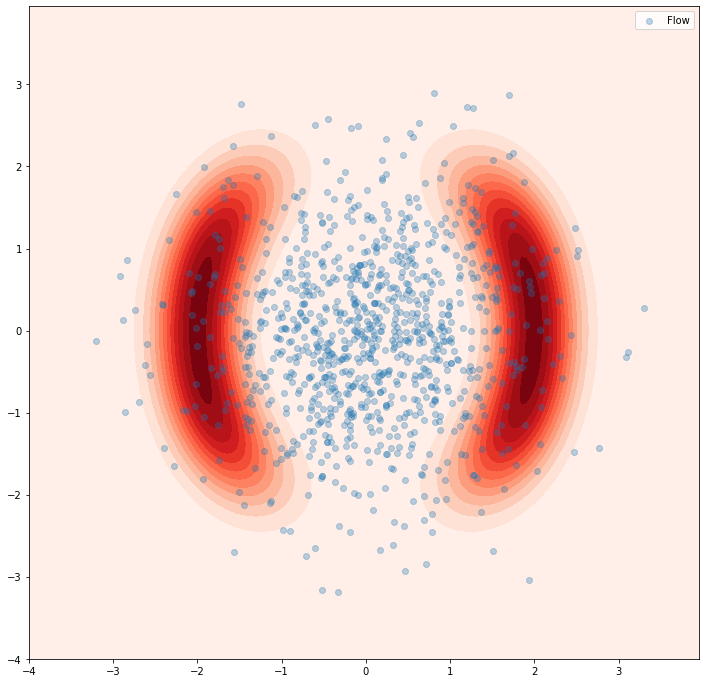

 42%|████▏     | 84/200 [00:08<00:13,  8.61it/s]

[[-1.42424142e-04 -7.10768721e-05  6.27812320e-06 -1.07561866e-04
   1.94499039e-04]
 [ 0.00000000e+00  0.00000000e+00 -1.63531878e-04 -4.63301741e-04
   2.04479016e-04]]
[[-2.18041748e-04 -2.05722925e-04  2.14577722e-05 -3.18786817e-05
  -2.12251866e-05]
 [ 0.00000000e+00  0.00000000e+00  7.94733806e-05 -1.02413857e-04
  -2.29639054e-04]]
[[ 3.27048969e-04  5.48560741e-05 -5.49103183e-05  8.86202675e-05
   9.57655413e-05]
 [ 0.00000000e+00  0.00000000e+00  3.61844358e-04 -1.31068945e-04
   1.52281075e-04]]


 43%|████▎     | 86/200 [00:09<00:12,  9.12it/s]

[[ 1.41438194e-05 -9.28770545e-05  4.65262375e-05 -1.46142132e-04
   9.30725218e-04]
 [ 0.00000000e+00  0.00000000e+00  1.05516059e-04  5.15332890e-05
   9.19364415e-05]]
[[-1.48013292e-04 -3.20192552e-06 -1.30819718e-05  2.99538733e-05
  -4.77822365e-04]
 [ 0.00000000e+00  0.00000000e+00 -1.59419160e-04  3.70099921e-05
  -8.95146597e-04]]
[[ 3.67777635e-04  6.06806863e-04 -8.28407087e-05 -4.86118228e-04
   3.44440890e-04]
 [ 0.00000000e+00  0.00000000e+00 -8.75122348e-06 -1.73903874e-05
  -4.20023395e-07]]


 45%|████▌     | 90/200 [00:09<00:10, 10.48it/s]

[[ 4.93683979e-05  1.61805628e-04 -1.36604652e-05  8.82393031e-04
  -4.61321386e-04]
 [ 0.00000000e+00  0.00000000e+00  1.65490144e-07  3.65360292e-05
  -8.83739167e-05]]
[[ 1.78533931e-04  2.85492901e-04 -7.63555080e-05  1.68518664e-04
   2.77304813e-04]
 [ 0.00000000e+00  0.00000000e+00 -2.94879726e-04 -8.06388589e-05
  -1.62917813e-04]]
[[-1.95467827e-04 -7.12038620e-04  1.52999298e-04  4.43052507e-05
  -1.80915987e-04]
 [ 0.00000000e+00  0.00000000e+00 -2.68877107e-04 -6.66293306e-05
  -6.37804017e-04]]
[[0.00024296 0.00063155 0.00020252 0.00038034 0.00024013]
 [0.         0.         0.00048751 0.00073181 0.0004871 ]]


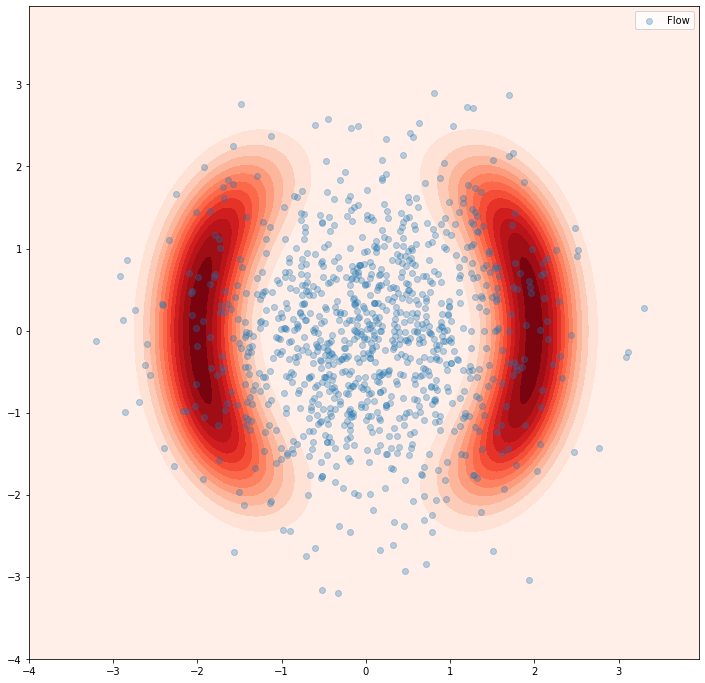

 47%|████▋     | 94/200 [00:10<00:12,  8.68it/s]

[[ 7.13471981e-05 -2.05392244e-04  7.93657067e-05 -2.64051427e-04
  -1.21309164e-04]
 [ 0.00000000e+00  0.00000000e+00 -2.11604452e-04 -1.21629449e-04
   3.81491218e-05]]
[[ 8.96858928e-05  9.98346118e-06 -2.42021019e-05 -2.75756936e-05
  -1.34686717e-07]
 [ 0.00000000e+00  0.00000000e+00  1.14988698e-04 -4.52421151e-05
  -1.31552025e-04]]
[[ 2.68021426e-06  9.93293042e-05 -1.58760026e-04  6.97038724e-05
  -8.47188069e-06]
 [ 0.00000000e+00  0.00000000e+00  3.29861128e-05 -8.36688143e-07
  -1.98004344e-06]]


 48%|████▊     | 96/200 [00:10<00:10,  9.73it/s]

[[ 1.58659128e-05  1.04014931e-04 -9.32578489e-06  3.90122228e-05
   6.19493401e-06]
 [ 0.00000000e+00  0.00000000e+00 -3.38982295e-05 -5.39793824e-04
   1.27308440e-04]]
[[ 4.81746821e-05  4.26009246e-05  1.50534575e-05 -2.99008873e-05
   1.12368245e-05]
 [ 0.00000000e+00  0.00000000e+00  1.63990748e-05 -5.49166258e-05
   1.87457120e-05]]
[[-6.27130707e-04 -1.75306887e-04  4.86577762e-04  1.45480372e-04
  -1.53592531e-03]
 [ 0.00000000e+00  0.00000000e+00 -2.23601877e-04  3.19497088e-05
  -5.07810002e-05]]


 50%|█████     | 100/200 [00:10<00:09, 10.82it/s]

[[-9.36828008e-05  2.60400249e-04  1.36473747e-05  1.52324692e-04
  -6.58045811e-05]
 [ 0.00000000e+00  0.00000000e+00 -1.69528481e-05  2.71509341e-05
   5.90692136e-06]]
[[-1.06960073e-04 -9.11060654e-06  2.64729940e-04 -3.35859466e-05
   6.64974923e-05]
 [ 0.00000000e+00  0.00000000e+00  3.59690602e-05 -1.51788807e-05
   5.48262405e-05]]
[[ 0.00023493  0.00034013 -0.00013554  0.00023607  0.00029296]
 [ 0.          0.         -0.00037496  0.00010339 -0.00049898]]
[[-1.65342432e-04 -6.62249157e-04  5.27231855e-05  1.53396290e-04
  -2.20224947e-05]
 [ 0.00000000e+00  0.00000000e+00 -2.30895569e-04 -1.39997739e-03
  -7.73153853e-04]]


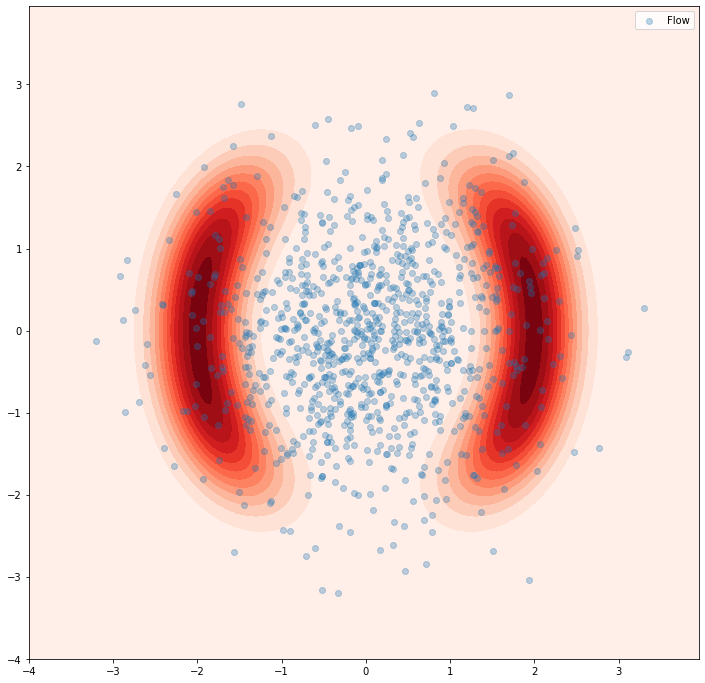

 52%|█████▏    | 104/200 [00:11<00:11,  8.68it/s]

[[ 1.18065670e-05  5.37951022e-05  7.61166515e-05  7.39100621e-05
  -6.46764636e-06]
 [ 0.00000000e+00  0.00000000e+00 -1.97648304e-05 -9.00278678e-06
   5.95323691e-05]]
[[-2.22712614e-04 -3.14920591e-04 -2.75041587e-04 -1.35341994e-05
  -8.82837507e-05]
 [ 0.00000000e+00  0.00000000e+00 -2.84987268e-04  8.61453015e-05
  -9.48763976e-05]]
[[-1.25047522e-03 -6.50911590e-06  5.07383523e-06 -3.60038978e-06
   1.61750013e-05]
 [ 0.00000000e+00  0.00000000e+00 -9.21009966e-04 -3.74864099e-05
   1.06945418e-03]]


 53%|█████▎    | 106/200 [00:11<00:09,  9.59it/s]

[[-0.00113591 -0.00018869  0.00049628 -0.00014862  0.00065511]
 [ 0.          0.          0.00074443 -0.00020443  0.001139  ]]
[[-6.61807020e-05 -2.04683558e-05  1.25205532e-05  2.75671846e-06
  -5.33338993e-06]
 [ 0.00000000e+00  0.00000000e+00  5.69954938e-05  8.72021170e-06
  -1.61065063e-04]]
[[ 0.00042145  0.00026491  0.00051172  0.00015359 -0.00011858]
 [ 0.          0.         -0.00093865 -0.00026507 -0.00044649]]


 55%|█████▌    | 110/200 [00:11<00:08, 10.46it/s]

[[ 7.08102642e-05 -6.75168431e-05 -3.30644051e-05  2.57046013e-04
  -3.83893768e-05]
 [ 0.00000000e+00  0.00000000e+00 -3.24686441e-05 -9.09635769e-05
   7.02395113e-06]]
[[ 2.74060747e-04  5.80734697e-05  6.83863093e-05  1.12357284e-04
  -4.10304723e-04]
 [ 0.00000000e+00  0.00000000e+00  8.69888882e-06 -2.24983391e-05
  -1.08733697e-05]]
[[ 2.17607513e-05  4.59173838e-06  7.25557822e-05 -6.05040508e-06
   4.62309111e-05]
 [ 0.00000000e+00  0.00000000e+00 -1.57941282e-05  7.03117762e-05
   9.68441659e-06]]
[[-5.28458842e-04 -5.02271668e-05  1.08254402e-04  4.93681092e-05
   6.62404182e-05]
 [ 0.00000000e+00  0.00000000e+00 -1.94468905e-04  1.11227309e-05
   1.13166167e-04]]


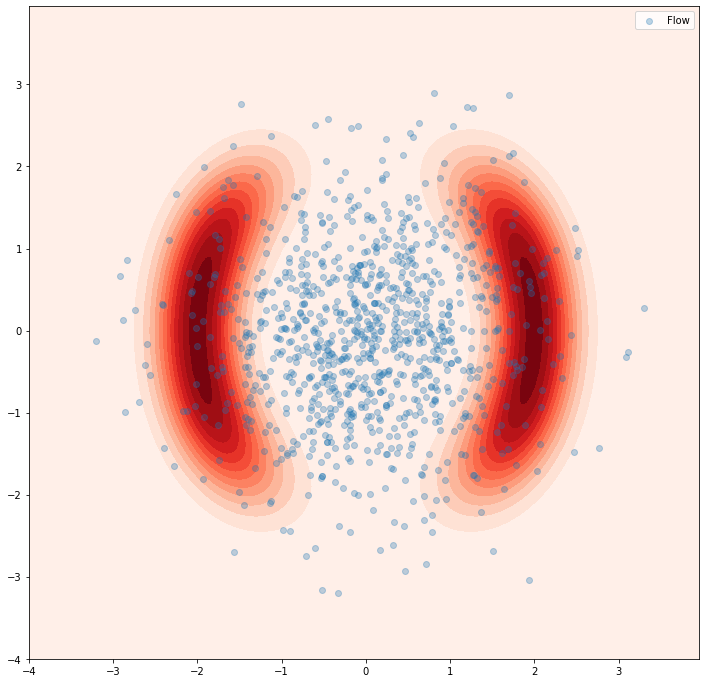

 57%|█████▋    | 114/200 [00:12<00:09,  8.86it/s]

[[ 1.37630816e-05  2.09528236e-05 -6.15280198e-05  6.71291427e-05
  -2.71695177e-05]
 [ 0.00000000e+00  0.00000000e+00 -1.02679813e-05 -8.83758833e-06
  -1.38315090e-05]]
[[-7.41207223e-05 -9.15221844e-05  1.14658880e-04 -8.09201822e-05
  -3.52768463e-04]
 [ 0.00000000e+00  0.00000000e+00 -1.74349516e-04  2.80053029e-05
  -1.25707901e-04]]
[[-1.00789102e-04 -2.68680236e-04 -1.25359892e-05  1.39388308e-04
  -2.83747266e-04]
 [ 0.00000000e+00  0.00000000e+00  5.44766966e-07 -1.08383139e-06
   3.22554398e-06]]
[[-3.04700648e-05 -4.14317415e-05 -3.42213603e-06 -6.64588140e-06
  -2.79403522e-06]
 [ 0.00000000e+00  0.00000000e+00 -6.39767850e-06 -3.31430617e-05
  -6.24824932e-06]]


 59%|█████▉    | 118/200 [00:12<00:07, 10.34it/s]

[[-4.44720928e-05 -3.43725134e-04 -8.35378732e-05 -8.74449942e-04
  -2.84046038e-04]
 [ 0.00000000e+00  0.00000000e+00  2.09787872e-05  4.68726115e-04
  -1.92543634e-04]]
[[ 1.09475147e-05 -6.29361896e-05 -2.25272207e-05  3.43356785e-05
   3.82218284e-06]
 [ 0.00000000e+00  0.00000000e+00  1.41437435e-05  8.02402227e-05
   1.13962393e-04]]
[[ 2.57871712e-04  9.86836778e-05 -7.03825474e-05 -5.94816250e-05
   1.03480018e-04]
 [ 0.00000000e+00  0.00000000e+00 -7.85162193e-05 -1.12100737e-04
   9.70595418e-05]]


 60%|██████    | 120/200 [00:12<00:07, 10.42it/s]

[[-1.45787498e-04 -1.87438750e-05 -6.32845323e-05  4.72554063e-05
   1.94213275e-05]
 [ 0.00000000e+00  0.00000000e+00  1.18667569e-06 -1.15764200e-05
   1.45746891e-04]]
[[ 4.18867622e-04  6.62627166e-04  1.92304746e-04 -1.31097957e-03
   7.19913392e-04]
 [ 0.00000000e+00  0.00000000e+00 -7.65756675e-06  2.28621585e-04
   4.53602986e-05]]
[[-5.27060811e-04 -3.73883676e-04 -3.05940745e-04  3.61185497e-06
   6.77884579e-04]
 [ 0.00000000e+00  0.00000000e+00  4.52477274e-05 -1.33733529e-04
  -3.25482313e-05]]


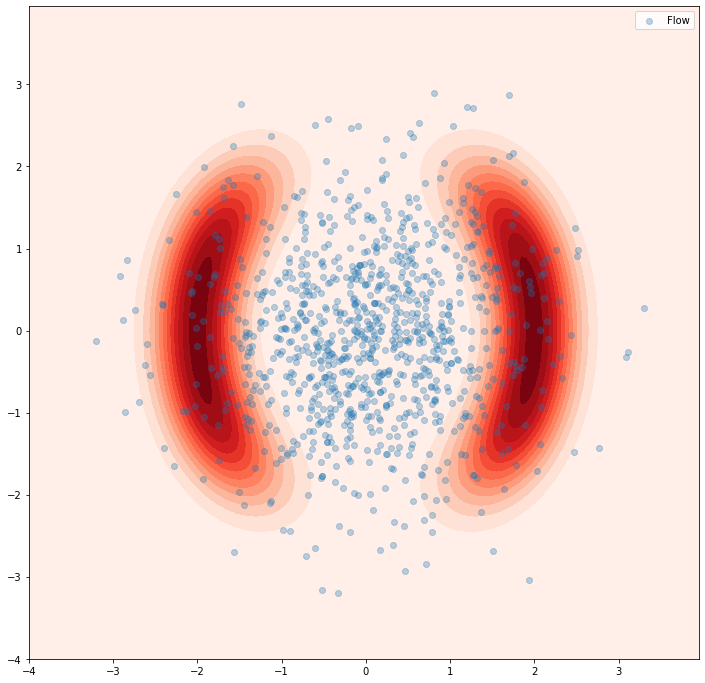

 62%|██████▏   | 123/200 [00:13<00:09,  8.20it/s]

[[-1.56407419e-04 -2.49010064e-05 -1.38260096e-04  3.32545281e-05
   1.86448199e-05]
 [ 0.00000000e+00  0.00000000e+00  2.24095664e-04 -4.54329593e-05
   1.43310683e-04]]
[[-8.10055281e-05 -1.68037404e-04 -2.22873123e-04  7.87488524e-05
   5.52775829e-05]
 [ 0.00000000e+00  0.00000000e+00 -5.26925424e-06 -2.03358963e-06
   9.05779547e-06]]
[[-3.74210396e-04 -1.77935914e-04 -3.61539859e-04  1.73383265e-04
  -4.12433418e-05]
 [ 0.00000000e+00  0.00000000e+00 -4.25525996e-04 -1.91495647e-04
  -1.31728232e-04]]


 64%|██████▎   | 127/200 [00:13<00:07, 10.12it/s]

[[-7.06522766e-06 -1.14021677e-04 -2.35974565e-05  5.96308368e-05
  -1.98130513e-04]
 [ 0.00000000e+00  0.00000000e+00  2.30455297e-05  3.49255972e-04
  -4.14964574e-04]]
[[ 2.16456384e-06 -5.83244933e-05  7.79126324e-06 -2.73581721e-05
   4.59706690e-05]
 [ 0.00000000e+00  0.00000000e+00 -8.35849262e-06  1.17010943e-05
   1.87801469e-06]]
[[-1.15641736e-05 -5.71134635e-04 -5.29494348e-05 -4.63312545e-04
  -2.53044802e-04]
 [ 0.00000000e+00  0.00000000e+00  1.87618953e-07  3.70921231e-06
  -9.92319289e-07]]


 64%|██████▍   | 129/200 [00:13<00:06, 10.93it/s]

[[ 3.62728138e-04  6.38126597e-06 -1.80818104e-06  2.71012273e-06
   1.37609040e-06]
 [ 0.00000000e+00  0.00000000e+00 -8.07932816e-05  2.70844178e-06
  -1.12040128e-04]]
[[-2.32653291e-04 -3.17954102e-04 -2.03390111e-07 -1.28061862e-04
   6.38647789e-05]
 [ 0.00000000e+00  0.00000000e+00  2.08277356e-05 -2.81415076e-04
   8.67520590e-05]]
[[-6.12098271e-04  2.38203288e-04  8.81517348e-04 -6.95467771e-06
  -6.44126874e-04]
 [ 0.00000000e+00  0.00000000e+00  3.10233910e-04 -3.69383677e-04
   6.60003642e-05]]
[[-9.88501581e-05 -3.03184228e-05 -5.12666572e-06 -4.31243168e-05
   9.57185432e-06]
 [ 0.00000000e+00  0.00000000e+00 -2.59883961e-05  1.37748580e-05
   6.12079205e-06]]


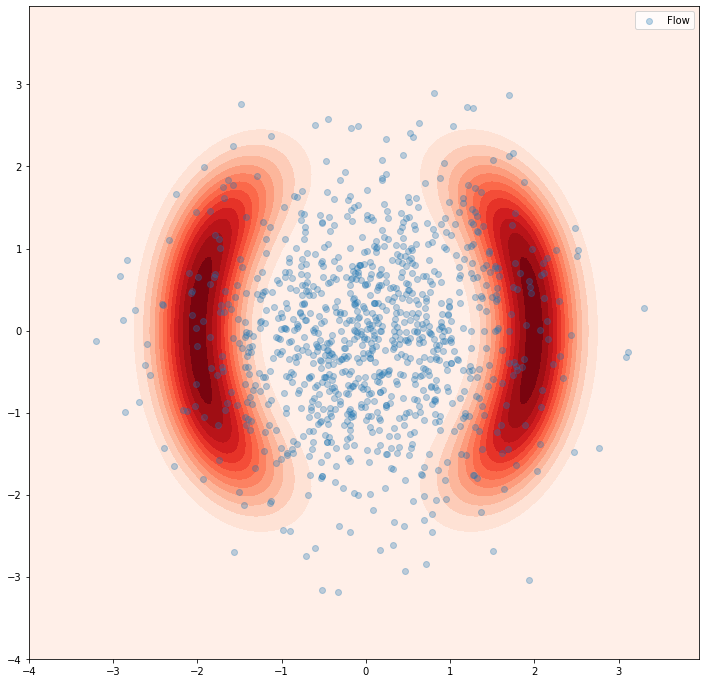

 66%|██████▋   | 133/200 [00:14<00:07,  9.50it/s]

[[-2.31925970e-05  8.18394500e-05  1.66694879e-04 -5.10859633e-04
   3.09573971e-04]
 [ 0.00000000e+00  0.00000000e+00  2.08943762e-04  6.41495343e-06
   2.21504612e-04]]
[[-1.19800008e-06 -4.27173632e-04  5.22359459e-06  7.14868275e-06
   1.08213951e-05]
 [ 0.00000000e+00  0.00000000e+00  2.49092884e-05 -1.62545040e-04
   6.86405498e-05]]
[[ 3.80563796e-04  1.24592985e-04  2.49214871e-06  4.02864877e-05
  -3.58982231e-05]
 [ 0.00000000e+00  0.00000000e+00 -3.26670909e-05  3.77850355e-04
  -8.84314520e-05]]


 68%|██████▊   | 135/200 [00:14<00:06, 10.33it/s]

[[-4.76847610e-05  9.63472309e-05 -5.27435805e-05  1.27167473e-06
   8.03629534e-05]
 [ 0.00000000e+00  0.00000000e+00 -1.45821751e-05  5.17825797e-05
   6.01210956e-05]]
[[-1.03118302e-05  1.87631621e-06  3.10030929e-06  1.61242968e-06
  -2.26805734e-05]
 [ 0.00000000e+00  0.00000000e+00 -1.69436881e-05  1.27298137e-06
  -1.40308072e-05]]


 70%|██████▉   | 139/200 [00:14<00:05, 11.06it/s]

[[-6.39873703e-06 -5.13938977e-05  7.18081768e-06  2.12494867e-04
  -1.11528872e-04]
 [ 0.00000000e+00  0.00000000e+00 -8.85255713e-05 -1.24907397e-04
  -1.53516321e-05]]
[[ 6.94947463e-05  6.80787314e-05 -6.16252024e-05 -7.44547779e-06
   1.25676507e-05]
 [ 0.00000000e+00  0.00000000e+00  1.53534951e-04 -1.28318688e-05
   6.49099636e-05]]
[[-1.38178227e-04 -5.41897240e-04  1.89304047e-05  1.69060815e-05
   6.90652374e-05]
 [ 0.00000000e+00  0.00000000e+00  1.41058186e-05  1.38429488e-04
   1.06477195e-04]]
[[ 2.09275693e-04  2.08412183e-04  9.23591588e-05  2.18879085e-07
  -4.44040691e-05]
 [ 0.00000000e+00  0.00000000e+00  6.29847845e-05  1.75447253e-05
  -3.15652264e-05]]
[[ 4.28831854e-04  2.18093480e-04  2.34012758e-06 -2.72370816e-05
  -2.42277277e-05]
 [ 0.00000000e+00  0.00000000e+00 -4.45123031e-07  1.11263928e-05
  -1.81799432e-06]]


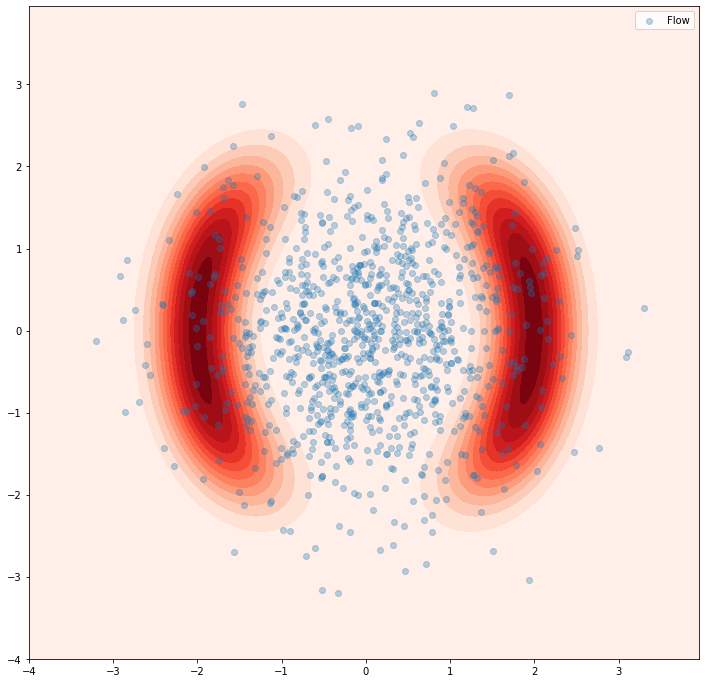

 72%|███████▏  | 143/200 [00:15<00:06,  8.60it/s]

[[ 1.80793810e-04  7.37047852e-04 -5.11672544e-04 -5.20187309e-04
  -1.14113808e-04]
 [ 0.00000000e+00  0.00000000e+00  7.47564629e-05  2.84598726e-06
   1.75323344e-04]]
[[ 1.04324669e-04  4.76503541e-05 -2.23713053e-05 -3.95295625e-05
  -1.10703809e-05]
 [ 0.00000000e+00  0.00000000e+00  9.51546488e-05  9.70495969e-05
  -3.76438381e-04]]
[[ 8.70093865e-06  1.42313957e-04 -5.62154784e-06  1.15981626e-04
  -2.35397895e-04]
 [ 0.00000000e+00  0.00000000e+00 -1.44815441e-07  4.16976502e-05
  -1.15365680e-05]]


 74%|███████▎  | 147/200 [00:15<00:05, 10.42it/s]

[[ 5.92350481e-05 -9.01253203e-05  1.37877626e-04 -2.10450716e-05
   1.83194889e-04]
 [ 0.00000000e+00  0.00000000e+00 -8.19997253e-05  1.09779510e-04
  -5.16558928e-05]]
[[ 7.18519991e-05  2.19985065e-05  1.18429682e-04 -1.13121365e-04
  -1.02502477e-04]
 [ 0.00000000e+00  0.00000000e+00 -3.80019426e-05 -8.34866074e-05
  -3.31979066e-05]]
[[-9.41145660e-06  8.65528660e-05  6.11154050e-05 -3.40467735e-06
  -3.99804029e-05]
 [ 0.00000000e+00  0.00000000e+00  4.73014502e-05 -6.15421497e-05
  -1.17725799e-04]]


 74%|███████▍  | 149/200 [00:15<00:04, 10.36it/s]

[[-2.31170884e-05 -5.52410342e-05  1.59022945e-05  8.89448804e-06
   1.07874401e-06]
 [ 0.00000000e+00  0.00000000e+00  5.50214156e-05 -4.08529569e-05
  -1.30809027e-06]]
[[ 8.78643371e-04  1.11422300e-04  3.87287485e-05 -7.25843971e-05
  -2.76059018e-05]
 [ 0.00000000e+00  0.00000000e+00  9.51008741e-05 -4.94223724e-04
  -4.14754618e-04]]
[[-1.57598841e-04 -3.96176874e-05 -2.13884432e-04  1.01385971e-04
  -1.41449387e-04]
 [ 0.00000000e+00  0.00000000e+00 -2.14755121e-04 -1.04181465e-05
  -4.38088383e-05]]
[[ 4.05962040e-04  6.39197162e-05 -1.62759111e-05  2.14443388e-05
  -1.96810642e-06]
 [ 0.00000000e+00  0.00000000e+00  1.51219432e-04 -1.93917327e-04
  -4.41055389e-05]]


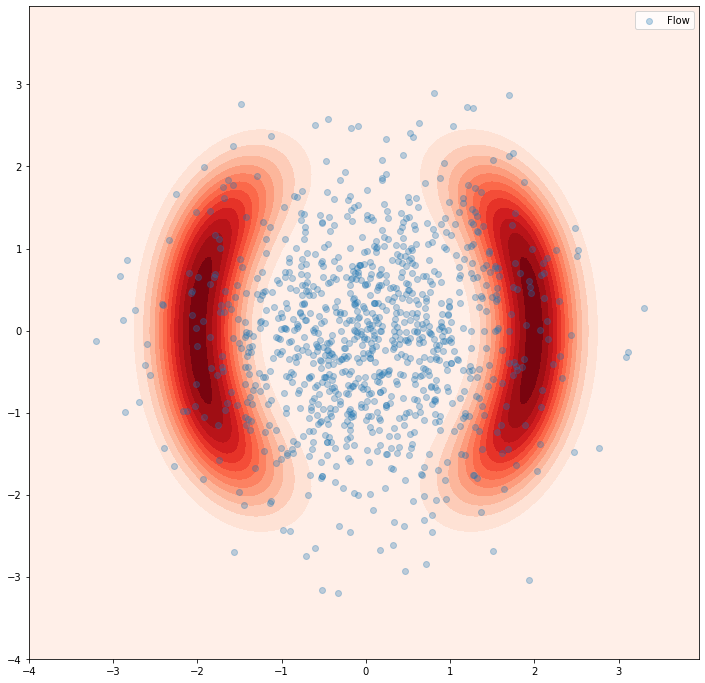

 77%|███████▋  | 154/200 [00:16<00:04,  9.38it/s]

[[-1.30045521e-04 -7.81697016e-05  5.80152307e-05 -1.93067969e-05
  -2.94565898e-05]
 [ 0.00000000e+00  0.00000000e+00 -7.53785586e-06 -8.93051091e-06
   4.71265183e-06]]
[[ 1.41243747e-04  3.13175967e-06 -8.30414950e-05  1.88201820e-05
   1.18879859e-04]
 [ 0.00000000e+00  0.00000000e+00  4.86096726e-05 -1.10108309e-05
   1.20957524e-04]]
[[ 6.27299736e-06  7.61926442e-05 -3.47404322e-05 -1.78740111e-04
  -7.39980012e-04]
 [ 0.00000000e+00  0.00000000e+00  1.55762534e-05 -2.92428309e-06
   2.80325953e-06]]
[[-1.47724336e-07  4.37536383e-05  5.50586977e-06 -1.51311347e-05
   2.42168160e-04]
 [ 0.00000000e+00  0.00000000e+00 -1.47707769e-05  1.13760124e-04
  -2.40320473e-04]]


 79%|███████▉  | 158/200 [00:16<00:03, 11.05it/s]

[[-1.94944314e-05  7.18946857e-07  2.86507280e-06  1.70951516e-05
   1.29636598e-06]
 [ 0.00000000e+00  0.00000000e+00 -2.00551566e-06  2.00356184e-05
  -2.24689095e-06]]
[[-8.33280271e-05 -2.12324415e-04  1.45833616e-04  6.60571809e-05
  -5.15827371e-05]
 [ 0.00000000e+00  0.00000000e+00 -6.05322996e-05  2.08576237e-05
  -2.41136391e-04]]
[[ 1.14786137e-04 -2.70814753e-05 -4.91198335e-04 -7.16266637e-05
   2.75687445e-04]
 [ 0.00000000e+00  0.00000000e+00 -1.43313787e-04  4.96363672e-05
   1.56491343e-04]]


 80%|████████  | 160/200 [00:16<00:03, 11.47it/s]

[[-1.28651559e-04 -1.05446223e-04 -1.43096214e-04 -1.34008722e-05
  -3.82128858e-05]
 [ 0.00000000e+00  0.00000000e+00 -1.90634041e-04  1.68791482e-05
  -1.55371226e-04]]
[[ 1.38255224e-05 -2.58352688e-05 -1.58975511e-05  1.53309692e-05
  -1.85665275e-05]
 [ 0.00000000e+00  0.00000000e+00  1.40779914e-05 -9.02743292e-05
  -4.41973038e-05]]
[[ 1.97312792e-06 -4.46849202e-04  1.36608181e-04 -8.64879116e-04
  -4.86252302e-04]
 [ 0.00000000e+00  0.00000000e+00 -1.14273275e-04  2.60657625e-04
  -1.60645692e-04]]


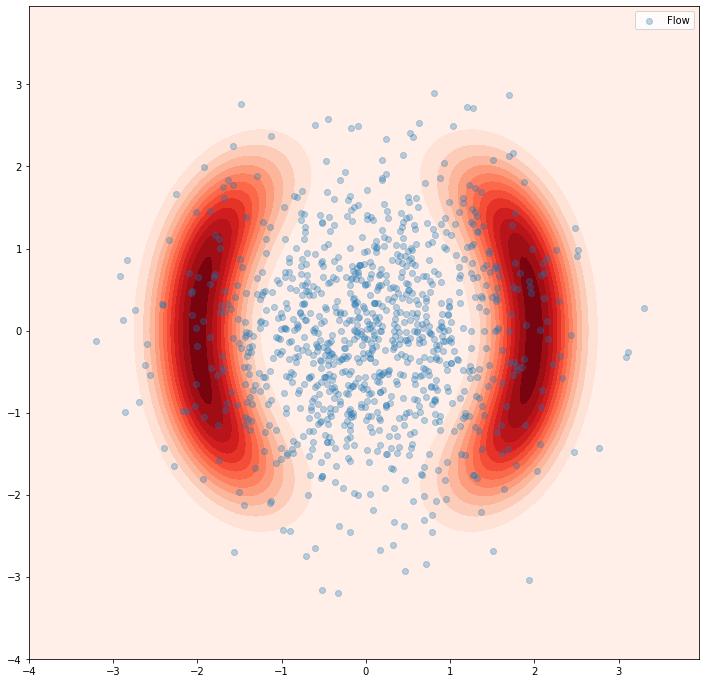

 82%|████████▏ | 164/200 [00:17<00:03,  9.10it/s]

[[ 0.00087765  0.00027478  0.00024518  0.00034754 -0.00030223]
 [ 0.          0.          0.00050056  0.00016004 -0.00068934]]
[[-2.22990223e-04 -1.45099705e-04  1.47782618e-05 -4.27194008e-05
   5.48804124e-04]
 [ 0.00000000e+00  0.00000000e+00  5.81338271e-06  6.86207645e-04
   2.38917126e-04]]
[[-1.39403891e-03 -6.16607340e-04  9.27271520e-05 -7.71555022e-05
  -5.27934237e-06]
 [ 0.00000000e+00  0.00000000e+00 -8.46553885e-04  2.60846484e-04
   1.06995953e-03]]


 83%|████████▎ | 166/200 [00:17<00:03,  9.74it/s]

[[-6.20993524e-04 -6.05269533e-04  5.22116702e-05 -3.56163114e-04
   3.27532740e-04]
 [ 0.00000000e+00  0.00000000e+00 -5.49601324e-05 -9.29781902e-06
   6.17392500e-05]]
[[-2.91743620e-05 -6.94176223e-05  2.26047599e-05 -7.61183160e-05
   2.21546110e-04]
 [ 0.00000000e+00  0.00000000e+00  4.83186329e-05  4.94557394e-05
  -3.55933594e-04]]
[[ 1.38562311e-04  1.28469222e-06  8.04506172e-06 -6.41168935e-06
   1.19860786e-06]
 [ 0.00000000e+00  0.00000000e+00  3.26288894e-05  1.93868744e-05
   3.30358157e-05]]


 84%|████████▍ | 168/200 [00:17<00:03, 10.37it/s]

[[ 1.87255137e-04  8.70804859e-05  8.15999339e-04  1.40640952e-04
   1.20989377e-04]
 [ 0.00000000e+00  0.00000000e+00 -2.89758683e-04 -8.39278428e-05
   4.91983155e-05]]
[[-2.48882551e-04 -4.12175173e-04 -5.41625811e-06  3.39753219e-04
  -4.51932513e-04]
 [ 0.00000000e+00  0.00000000e+00  2.00778089e-04 -3.27065886e-05
   1.11068358e-04]]


 85%|████████▌ | 170/200 [00:18<00:03,  9.87it/s]

[[-7.51710045e-06 -1.66579507e-05 -1.20248791e-08  5.55265290e-06
  -3.06110361e-04]
 [ 0.00000000e+00  0.00000000e+00  7.23190358e-07  7.66617971e-07
  -2.39583839e-06]]
[[-6.20563173e-06 -1.30169482e-05 -8.76171206e-06 -4.59569811e-05
  -8.49371311e-06]
 [ 0.00000000e+00  0.00000000e+00 -1.16126584e-05  5.23446034e-05
  -2.73863196e-04]]


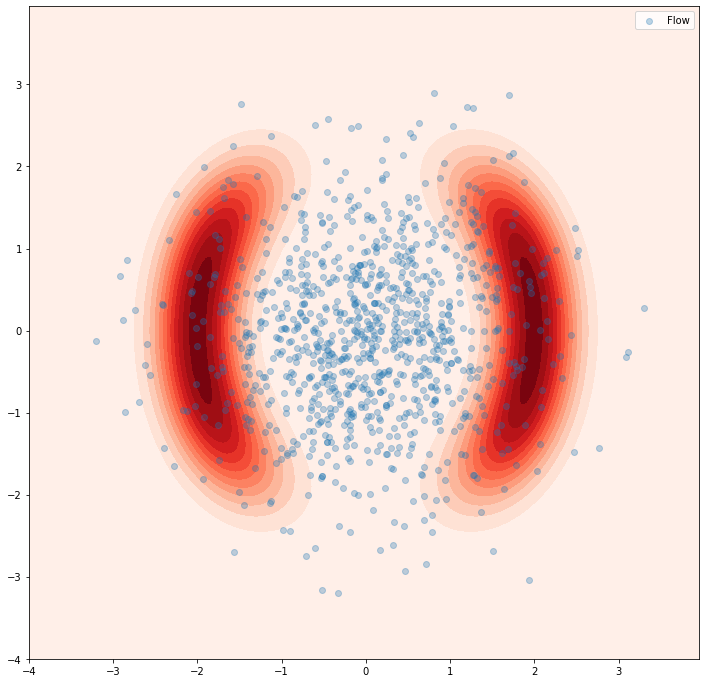

 87%|████████▋ | 174/200 [00:18<00:03,  8.20it/s]

[[-2.24666656e-05 -1.62065111e-06 -5.71392007e-05  2.58629335e-05
   9.27658670e-06]
 [ 0.00000000e+00  0.00000000e+00 -5.99458135e-06 -1.05170149e-05
   1.08622957e-05]]
[[ 2.83371348e-05  1.81002207e-04  1.65437026e-05  6.99112925e-05
   3.65290254e-05]
 [ 0.00000000e+00  0.00000000e+00 -4.07394850e-06  7.47984220e-05
   3.46055681e-05]]
[[-3.23814982e-04 -6.67495254e-05  1.59711172e-04 -3.13814948e-05
   5.92635817e-04]
 [ 0.00000000e+00  0.00000000e+00 -7.02991165e-05  9.72743168e-05
   3.84246460e-04]]


 88%|████████▊ | 176/200 [00:18<00:02,  9.22it/s]

[[-6.82286048e-05 -4.51003439e-04 -2.62883696e-05 -1.37083926e-05
   5.20223124e-06]
 [ 0.00000000e+00  0.00000000e+00 -9.47991205e-05 -7.84411670e-05
  -5.45007139e-05]]
[[ 7.96673860e-04  1.97947726e-04  3.57461067e-04 -1.82097392e-04
   2.72464545e-04]
 [ 0.00000000e+00  0.00000000e+00  7.47595938e-05  2.81806380e-05
   6.51903617e-05]]


 89%|████████▉ | 178/200 [00:19<00:02,  9.53it/s]

[[ 6.18672793e-04  1.70741726e-04  2.43876426e-04  3.03373075e-05
   2.18196700e-05]
 [ 0.00000000e+00  0.00000000e+00  5.54587220e-04 -6.03926837e-05
   8.67458569e-04]]
[[-9.90236091e-05 -2.41297788e-04 -4.83278252e-04 -2.18171982e-04
   1.61041116e-05]
 [ 0.00000000e+00  0.00000000e+00  1.42809466e-05 -3.67319941e-05
  -2.59710870e-05]]
[[ 2.03425905e-04  9.71835544e-05  2.15028723e-04  7.82694145e-05
   3.21457709e-04]
 [ 0.00000000e+00  0.00000000e+00  3.40387293e-04 -3.23083049e-04
   3.75687692e-03]]


 90%|█████████ | 180/200 [00:19<00:01, 10.45it/s]

[[-1.44752640e-04  3.23168693e-05 -5.23676665e-05  1.17809848e-04
  -3.43618228e-05]
 [ 0.00000000e+00  0.00000000e+00  1.22973054e-04  6.23755589e-05
  -9.03960595e-05]]
[[ 2.43119532e-04 -6.17654529e-04  2.59727755e-04  1.24804889e-03
  -2.82057071e-04]
 [ 0.00000000e+00  0.00000000e+00 -1.95714347e-04 -3.54110346e-05
   2.99462931e-04]]


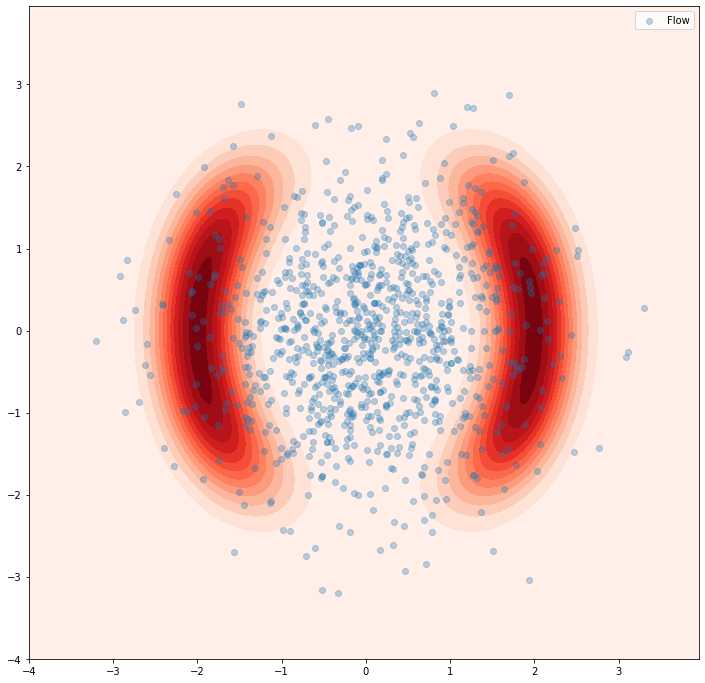

 92%|█████████▏| 184/200 [00:19<00:01,  8.64it/s]

[[-5.41830989e-04 -9.16395748e-05  1.44001085e-05  7.48138997e-05
  -7.99476289e-05]
 [ 0.00000000e+00  0.00000000e+00 -1.03884200e-03  1.42029954e-05
  -3.91581788e-04]]
[[-1.33336768e-04 -2.33823133e-04  3.70033847e-05  5.25624676e-05
   2.27326196e-05]
 [ 0.00000000e+00  0.00000000e+00 -1.72149432e-05  1.79916366e-04
   2.53901434e-04]]
[[ 2.63415931e-05  1.04793517e-04  1.85263630e-05 -2.05126200e-05
   2.66625723e-05]
 [ 0.00000000e+00  0.00000000e+00 -6.15803225e-05  3.71641240e-05
   4.78981986e-05]]


 93%|█████████▎| 186/200 [00:19<00:01,  9.39it/s]

[[ 8.15595768e-05  4.27717388e-04  1.51792169e-05 -2.33304975e-04
   4.28772134e-04]
 [ 0.00000000e+00  0.00000000e+00  2.81078484e-05 -6.47146050e-04
   1.35869002e-04]]
[[-1.35326010e-04 -1.02626324e-03 -1.76576339e-05  6.92611296e-06
  -2.05261281e-04]
 [ 0.00000000e+00  0.00000000e+00  1.24273537e-04 -4.29179531e-04
  -1.95497621e-04]]
[[ 1.66579274e-04  1.55567085e-05  2.29192141e-04  6.11081290e-06
  -1.95933583e-04]
 [ 0.00000000e+00  0.00000000e+00 -3.67150467e-05 -1.79800343e-06
  -3.75311942e-06]]


 95%|█████████▌| 190/200 [00:20<00:00, 10.79it/s]

[[ 4.37253516e-04  2.47873723e-05 -5.46157176e-05  1.29854496e-04
  -5.58405177e-05]
 [ 0.00000000e+00  0.00000000e+00 -2.62105415e-04  1.38785073e-04
  -4.11564955e-04]]
[[-9.70654776e-05 -2.45287316e-05  6.78453089e-05  1.25963894e-04
  -1.26930099e-04]
 [ 0.00000000e+00  0.00000000e+00 -3.97411722e-06  3.75746325e-05
  -6.24195595e-06]]
[[-1.67386128e-04 -2.97455829e-04 -1.65334032e-04 -3.26539909e-04
  -8.23967906e-04]
 [ 0.00000000e+00  0.00000000e+00  3.66029904e-05  1.39333077e-04
  -2.19690387e-05]]
[[ 1.67197256e-06  4.21952708e-05  2.76263239e-07  1.04583644e-05
  -3.57435435e-05]
 [ 0.00000000e+00  0.00000000e+00 -3.28250268e-06 -2.48734159e-05
  -5.08236229e-05]]


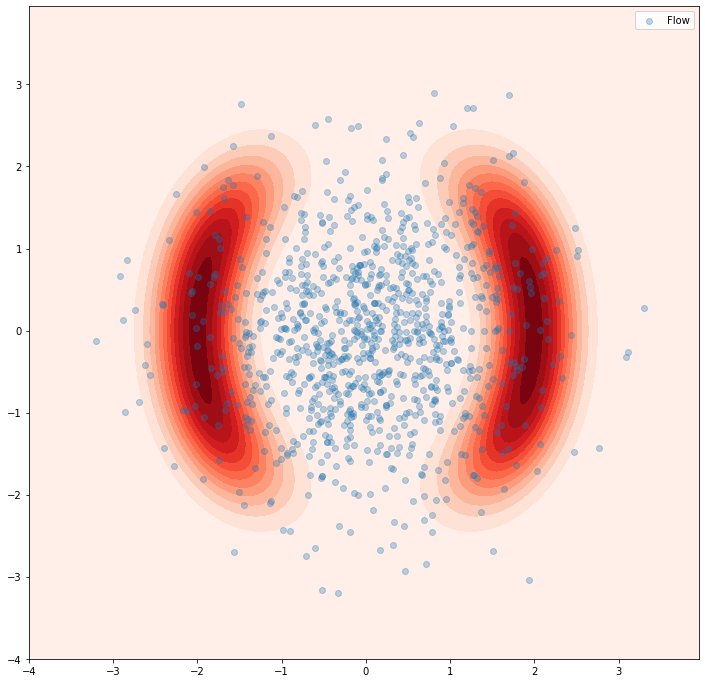

 97%|█████████▋| 194/200 [00:20<00:00,  9.20it/s]

[[ 5.28025328e-04  4.42923991e-05  2.19359301e-04 -2.48302444e-04
   1.05223057e-04]
 [ 0.00000000e+00  0.00000000e+00  7.57677427e-06 -6.20949750e-05
  -6.23480661e-05]]
[[ 0.00112158  0.00029794  0.00011696 -0.00056006 -0.00057405]
 [ 0.          0.          0.00080542  0.00029778 -0.00094205]]
[[-2.84265560e-04 -9.79017073e-05 -1.48277589e-04 -6.33129070e-05
  -9.42349363e-05]
 [ 0.00000000e+00  0.00000000e+00 -1.39404741e-05  2.70227588e-05
  -4.32055072e-05]]
[[ 1.20515667e-05  1.49424002e-05 -4.51866080e-05 -9.97354650e-05
  -2.09294588e-05]
 [ 0.00000000e+00  0.00000000e+00  3.52763998e-08 -6.26630217e-06
  -3.02917601e-05]]


 99%|█████████▉| 198/200 [00:21<00:00, 10.77it/s]

[[-4.82404878e-05 -8.55403841e-05 -8.13554156e-06 -1.12504349e-04
   7.48710984e-05]
 [ 0.00000000e+00  0.00000000e+00  4.38008727e-05 -1.02508074e-04
   1.96053900e-04]]
[[ 3.15805771e-05 -7.46685931e-05  1.19883061e-04  6.17345376e-05
  -3.76610437e-05]
 [ 0.00000000e+00  0.00000000e+00 -6.15484921e-05  1.25041827e-04
  -7.19097337e-05]]
[[ 0.00067139  0.00059338  0.00040493  0.00061957 -0.00042115]
 [ 0.          0.          0.00043898 -0.00013676 -0.00038554]]


100%|██████████| 200/200 [00:21<00:00,  9.39it/s]


[[-6.57750540e-05  1.72677441e-04  1.49642190e-04  1.57367568e-04
  -2.17552150e-05]
 [ 0.00000000e+00  0.00000000e+00 -6.68464860e-05  3.95424984e-04
   2.42696134e-04]]
[[ 1.08520481e-05  2.21280348e-04  3.63294829e-05 -7.46454593e-06
   1.02122805e-05]
 [ 0.00000000e+00  0.00000000e+00  1.25362153e-04 -3.12435883e-05
   8.68223047e-06]]
UPDATED PARAMETERS:
[[ 0.00450506 -0.00412897  0.00109369 -0.00773956 -0.00407499]
 [-0.00090925 -0.00263149  0.00534197  0.00409764 -0.00267033]]


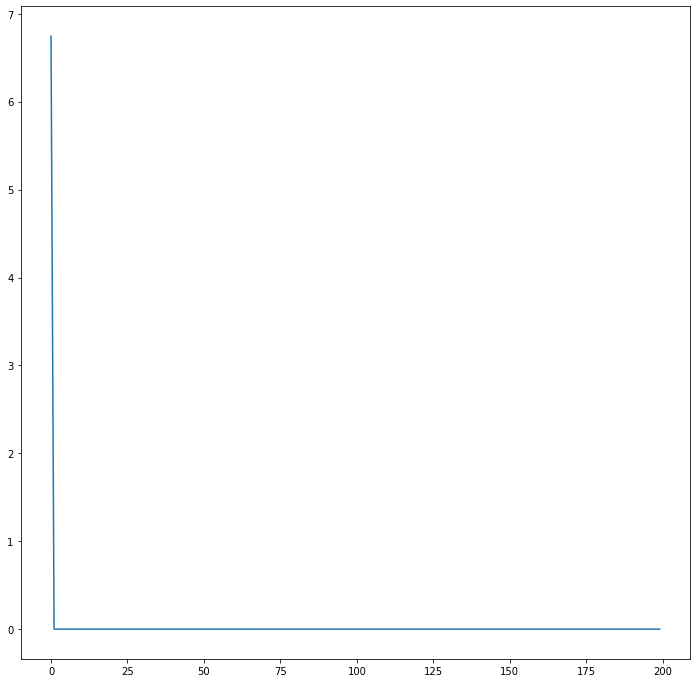

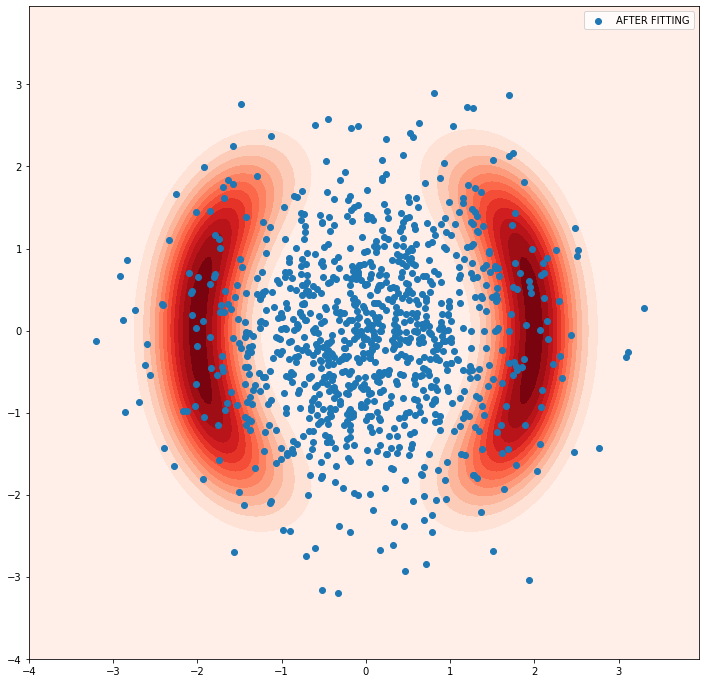

In [8]:
samples = np.random.multivariate_normal([0,0], np.eye(2), 1000)

new_lambda = np.copy(lbda)
elbo = []
print("ORIGINAL LAMDA:\n{}\n".format(new_lambda))
fig, ax = plt.subplots(figsize=(12,12))
ax.contourf(X, Y, u1(dat), cmap='Reds', levels=15) # Target distribution
ax.scatter(samples[:,0], samples[:,1])
plt.show()

for i in tqdm(range(200)):
    # Update model parameters
    grad_f_samples = grad_en_func(new_lambda)
    print(grad_f_samples)
    new_lambda = 0.0005*grad_f_samples + 0.005*np.random.randn(*grad_f_samples.shape)
    elbo.append(en_func(new_lambda))

    # Flow samples with new parameters
    new_flow_func = lambda z: flow(z, new_lambda[0], func)
    updated_flow_samples = new_flow_func(np.copy(samples))
    #print("UPDATED LAMBDA:\n{}\n".format(new_lambda))
    
    if i % 10 == 0:
        # Plot
        fig, ax = plt.subplots(figsize=(12,12))
        ax.contourf(X, Y, u1(dat), cmap='Reds', levels=15) # Target distribution
        ax.scatter(updated_flow_samples[:,0], updated_flow_samples[:,1], alpha=0.3, label="Flow")    
        ax.legend(loc='best')
        plt.show()

print("UPDATED PARAMETERS:\n{}".format(new_lambda))
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(elbo, label="FREE ENERGY")
plt.show()

fig, ax = plt.subplots(figsize=(12,12))
ax.contourf(X, Y, u1(dat), cmap='Reds', levels=15) # Target distribution
ax.scatter(updated_flow_samples[:,0], updated_flow_samples[:,1], label="AFTER FITTING")
#ax.scatter(samples[:,0], samples[:,1], label="ORIGINAL DATA", color='k')
ax.legend(loc='best')
plt.show()

# Fitting my own single planar transformation

LAMBDA: [[0.5 0.5 0.5 0.5 0.5]]
[[ 68.48754772  68.48754772 452.619031    -1.28859965 818.97942729]]


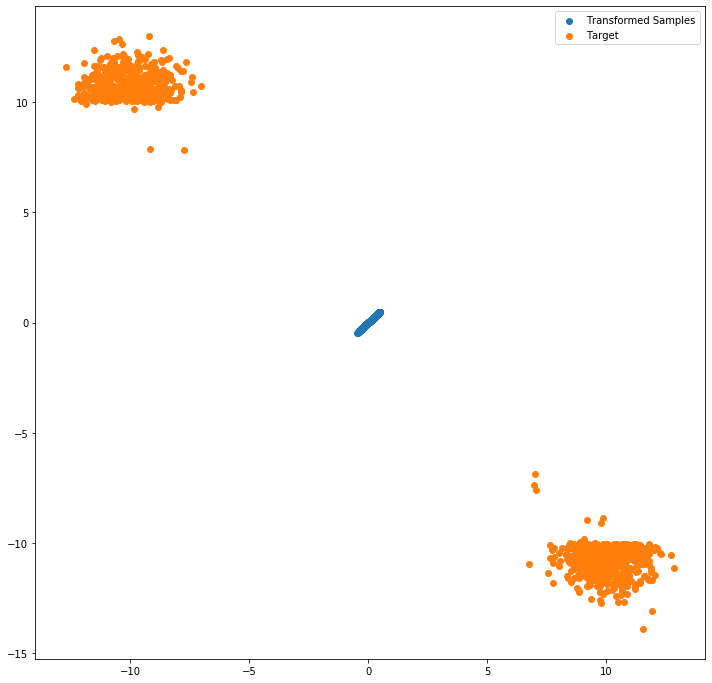

In [9]:
# Samples from initial distribution
samples = np.random.multivariate_normal([0,0], np.eye(2), 1000)

# Setting up flow parameters - splits data vertically, is a good example
#us = [np.array([3,0])]       #, np.array([0.5, 0.5]), np.array([-1, 1]), np.array([1, -1])]
#bs = [0]                     #, 1, 2, 3]
#ws = [np.array([15, 0])]     #, np.array([1,0]), np.array([0,1]), np.array([1,1])]
lbda = [np.array([-10., 10., 0., 150., 0.1])]


# Set up parameters for learning flow
flows = 1
func = lambda x: np.tanh(x)  # Function for transformation
#flow_func = [lambda z, lbda: psi(z, lbda, grad(func))]*flows
#target_samples = flow_samples(np.copy(samples), flow_func, lbda)
target_samples = flow(np.copy(samples), lbda[0], np.tanh)

lbda = np.array([np.ones(5)*0.5]*flows)
print("LAMBDA: {}".format(lbda))
flow_func = [lambda z, lbda: psi(z, lbda, grad(func))]*flows
func = lambda x: np.tanh(x)  # Function for transformation

p = lambda x: np.log(norm.pdf(x[1] - np.sin(x[0]), 0, 0.1))
p = lambda x: np.log(multivariate_normal.pdf(x, [3,3], [[1,-5],[0,1]]))
q = lambda z: np.log(multivariate_normal.pdf(z, [0,0], np.eye(2)))

en = free_energy(samples, lbda, q, p, flow_func, target_samples)
en_func = lambda lmda: free_energy(samples, lmda, q, p, flow_func, target_samples)
#print(samples.shape)
#print("ONE PARTICULAR LAMBDA: {}".format(en_func(lbda)))
grad_en_func = grad(en_func)
grad_f_samples = grad_en_func(lbda)
print(grad_f_samples)

# Generate new samples from flow
#print("LAMBDA: {}".format(lbda))
transformed_samples = flow_samples(samples, flow_func, lbda)
#print(transformed_samples.shape)

fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(transformed_samples[:,0], transformed_samples[:,1], label="Transformed Samples")
ax.scatter(target_samples[:,0], target_samples[:,1], label="Target")
ax.legend(loc='best')
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

NEW LAMBDA BEFORE:
[[0.5 0.5 0.5 0.5 0.5]]
[[ 68.48754772  68.48754772 452.619031    -1.28859965 818.97942729]]
[[1.18487548 1.18487548 5.02619031 0.487114   8.68979427]]


/home/elisionducoeur/anaconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


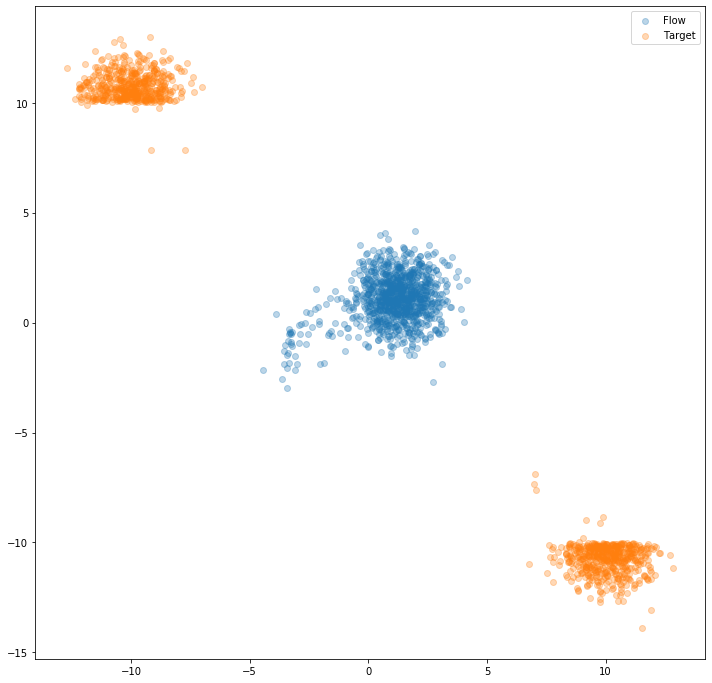

 10%|█         | 1/10 [00:00<00:03,  2.76it/s]

[[806.94169919   7.57923776 399.18836747 192.95984845 533.83355782]]
[[ 9.25429247  1.26066785  9.01807398  2.41671249 14.02812985]]


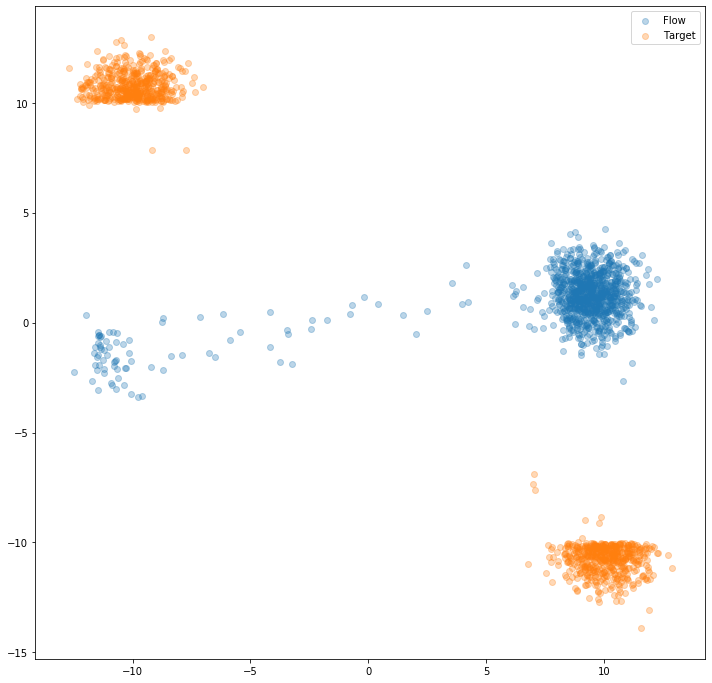

 20%|██        | 2/10 [00:00<00:02,  2.89it/s]

[[  106.90093218     7.67721807 -1004.60373748   -17.75810061
    458.26617965]]
[[10.32330179  1.33744004 -1.02796339  2.23913148 18.61079165]]


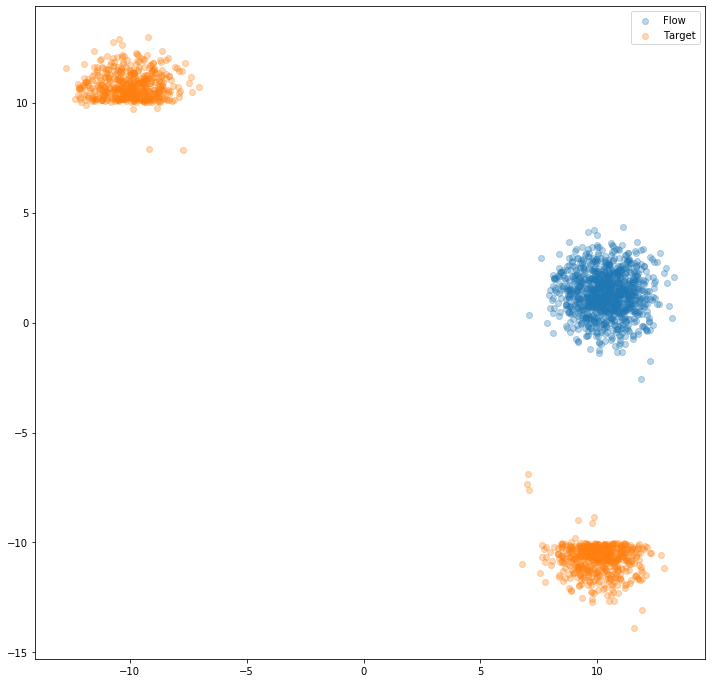

 30%|███       | 3/10 [00:00<00:02,  2.99it/s]

[[ 5.67687767e+01  2.69347799e+02 -3.56968011e+02  3.97851369e+02
   8.61808876e-08]]
[[10.89098956  4.03091803 -4.5976435   6.21764517 18.61079165]]


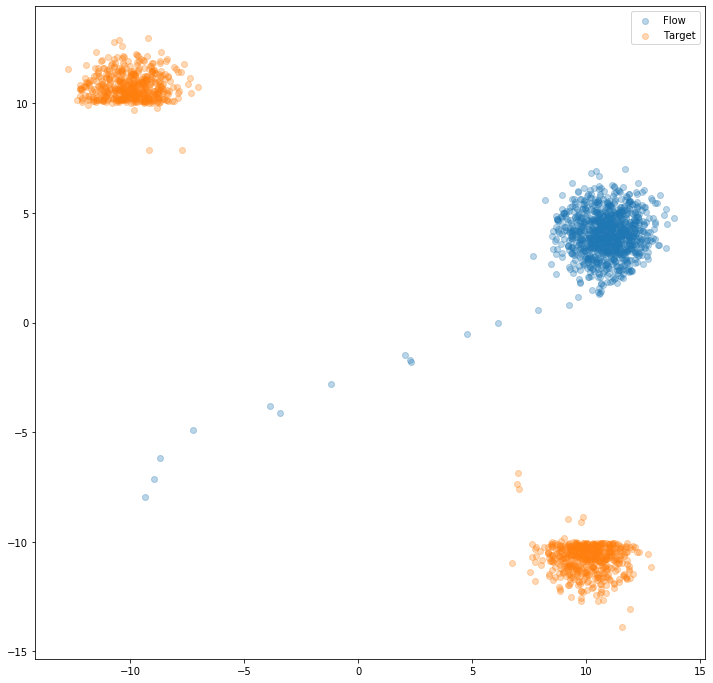

 40%|████      | 4/10 [00:01<00:02,  2.92it/s]

[[  54.56373388   99.78961897 -434.71153154 -646.07860596  320.70057458]]
[[11.4366269   5.02881422 -8.94475881 -0.24314089 21.81779739]]


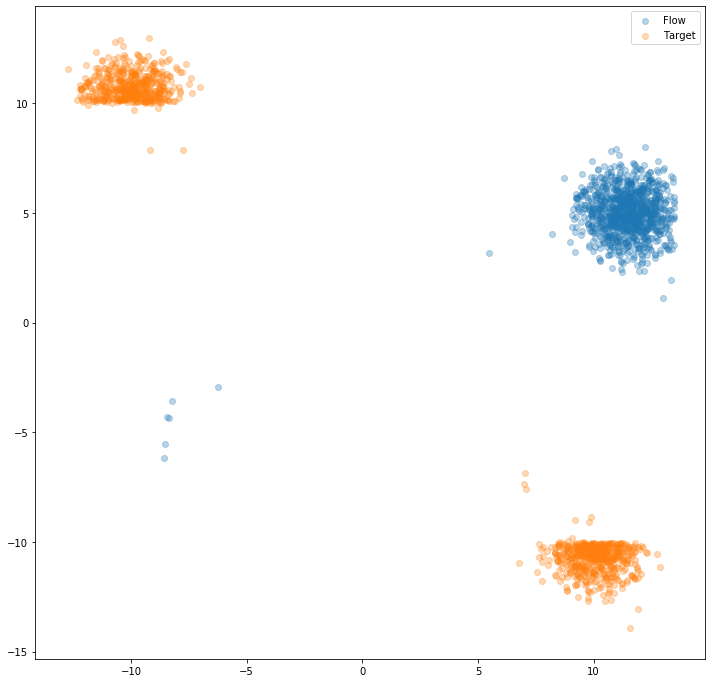

 50%|█████     | 5/10 [00:01<00:01,  3.10it/s]

[[ 8.73154754e+01  6.45163735e-02  2.48726434e+03  2.84706248e+02
  -3.42964516e+01]]
[[12.30978165  5.02945938 15.92788463  2.6039216  21.47483288]]


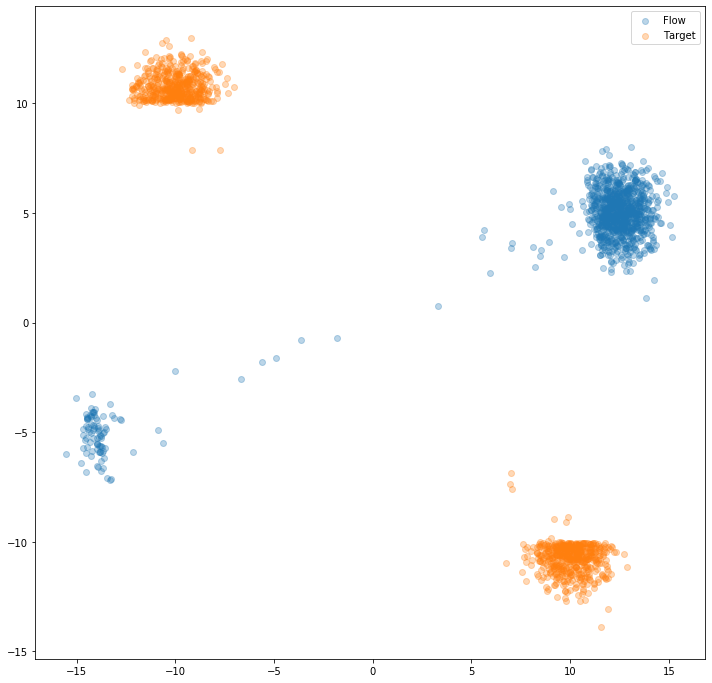

 60%|██████    | 6/10 [00:01<00:01,  3.20it/s]

[[   80.33877009     2.14716185 -1690.52006444   -66.58150272
    304.71140789]]
[[13.11316935  5.050931   -0.97731601  1.93810657 24.52194696]]


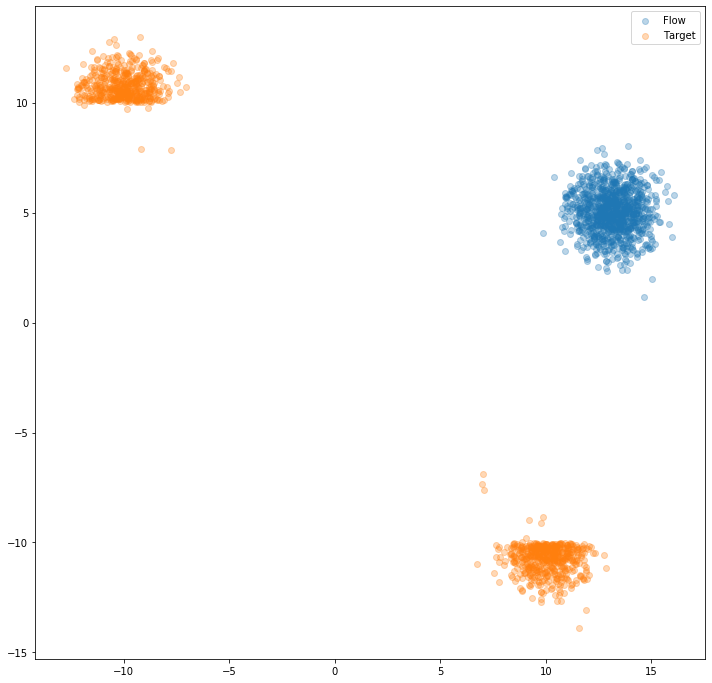

 70%|███████   | 7/10 [00:02<00:00,  3.31it/s]

[[2.93913013e+01 1.15585697e+02 1.39960834e+02 7.08648866e+02
  4.57613508e-14]]
[[13.40708236  6.20678797  0.42229233  9.02459523 24.52194696]]


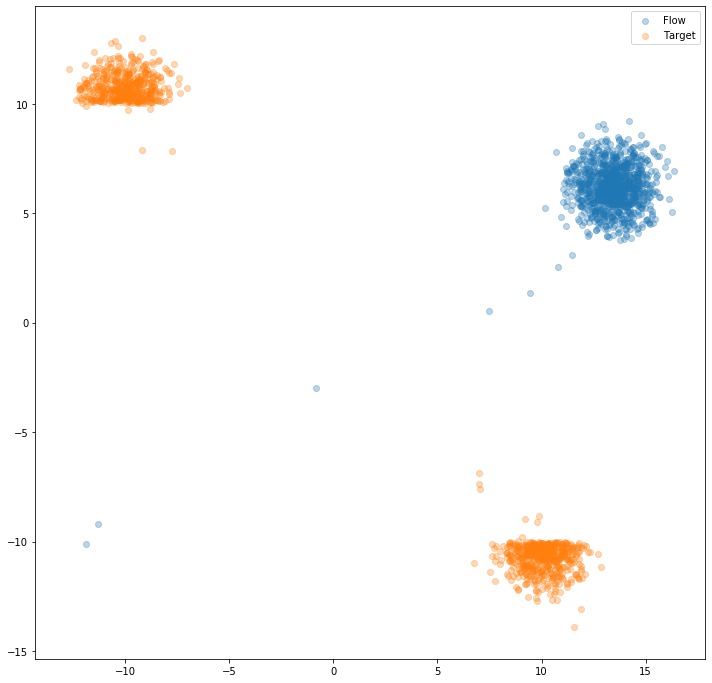

 80%|████████  | 8/10 [00:02<00:00,  3.45it/s]

[[ 3.50448302e-01  1.60049028e+02 -2.72473054e+03 -3.20346109e+02
  -2.27763609e+01]]
[[ 13.41058685   7.80727826 -26.82501306   5.82113414  24.29418335]]


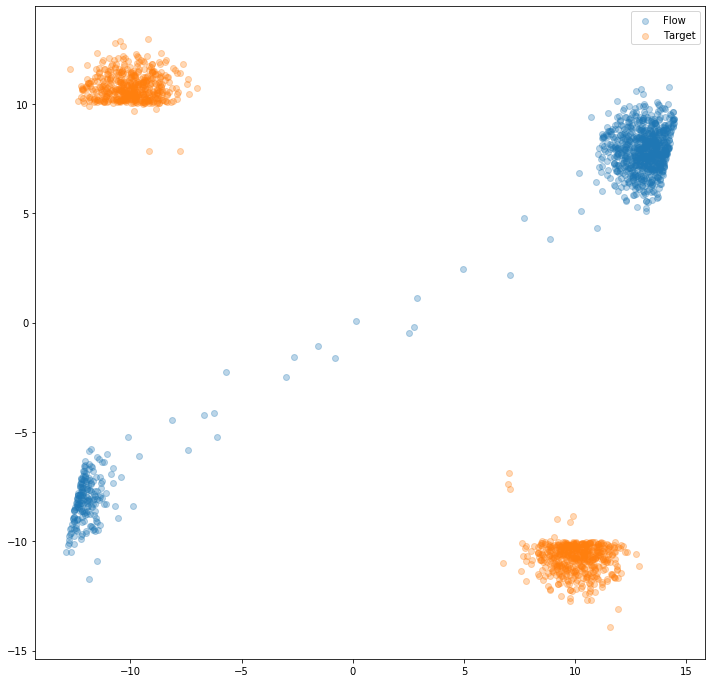

 90%|█████████ | 9/10 [00:02<00:00,  3.32it/s]

[[  72.57405246    3.41756438  -47.72660116 -226.54098931 -923.33279626]]
[[ 14.13632737   7.8414539  -27.30227907   3.55572425  15.06085539]]


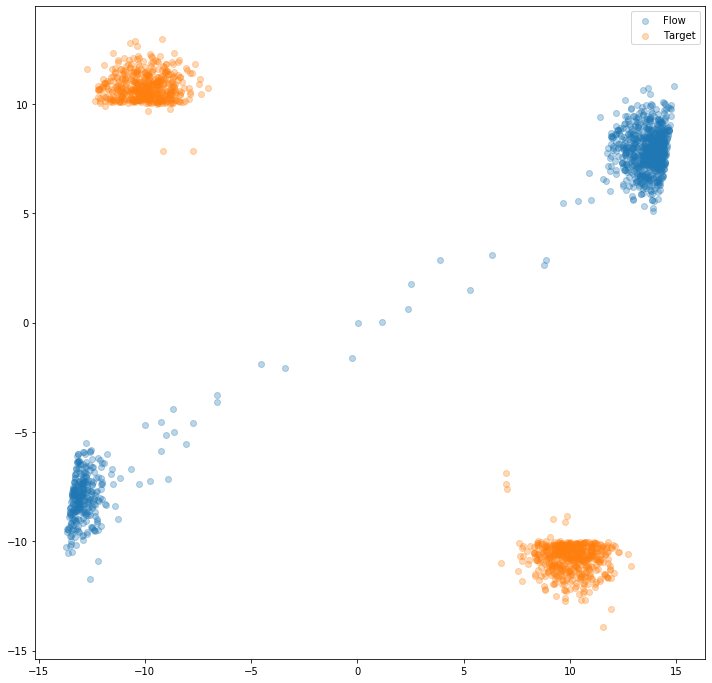

100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


NEW LAMBDA AFTER:
[[ 14.13632737   7.8414539  -27.30227907   3.55572425  15.06085539]]


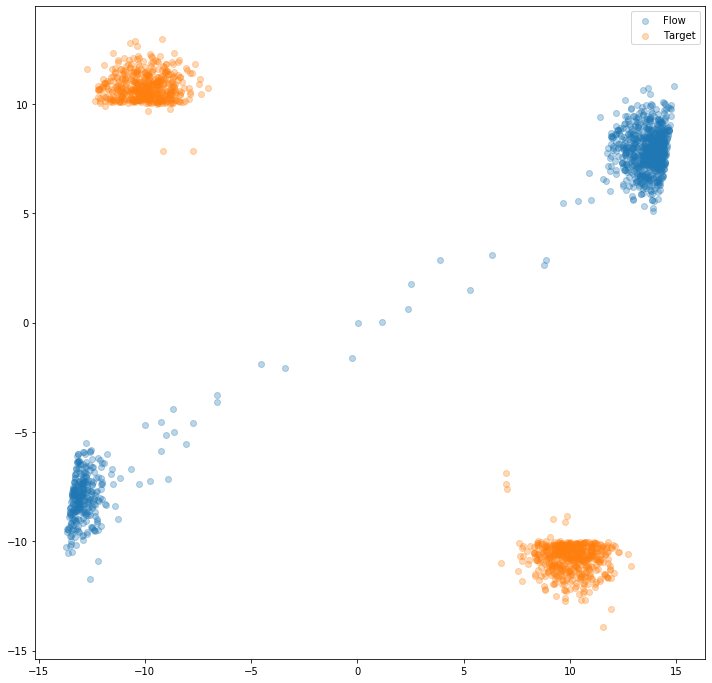

In [10]:
new_lambda = np.copy(lbda)
elbo = []
print("NEW LAMBDA BEFORE:\n{}".format(new_lambda))

# Attempts to find parameters with stochastic gradient descent
for i in tqdm(range(10)):
    grad_f_samples = grad_en_func(new_lambda)
    print(grad_f_samples)
    new_lambda += 0.01*grad_f_samples #+ np.random.randn(*new_lambda.shape)*0.05
    print(new_lambda)
    elbo.append(en_func(grad_f_samples))

    new_flow_func = lambda z: flow(z, new_lambda[0], func)
    updated_flow_samples = new_flow_func(samples)
    
    fig, ax = plt.subplots(figsize=(12,12))
    ax.scatter(updated_flow_samples[:,0], updated_flow_samples[:,1], alpha=0.3, label="Flow")
    ax.scatter(target_samples[:,0], target_samples[:,1], alpha=0.3, label="Target")
    ax.legend(loc='best')
    plt.show()

print("NEW LAMBDA AFTER:\n{}".format(new_lambda))
grad_f_samples = grad_f_samples[0]

# Compute old samples through new fitted flow
new_flow_func = lambda z: flow(z, new_lambda[0], func)
updated_flow_samples = new_flow_func(samples)
#fig, ax = plt.subplots(ncols=2, figsize=(20,12))
#ax[0].scatter(updated_flow_samples[:,0], updated_flow_samples[:,1], alpha=0.3, label="Flow")
#ax[0].scatter(target_samples[:,0], target_samples[:,1], alpha=0.3, label="Target")
#ax[1].plot(elbo)
#ax[0].legend(loc='best')
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(updated_flow_samples[:,0], updated_flow_samples[:,1], alpha=0.3, label="Flow")
ax.scatter(target_samples[:,0], target_samples[:,1], alpha=0.3, label="Target")
ax.legend(loc='best')
plt.show()

In [11]:
print(new_lambda)

[[ 14.13632737   7.8414539  -27.30227907   3.55572425  15.06085539]]


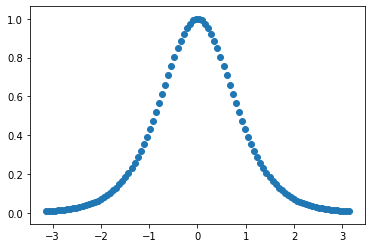

In [12]:
fig, ax = plt.subplots()
xs = np.linspace(-np.pi, np.pi, 100)
grad_f = grad(np.tanh)
plot_vals = []
for x in xs:
    plot_vals.append(grad_f(x))
ax.scatter(xs, plot_vals)